In [1]:
from __future__ import print_function
import argparse
import datetime
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import clear_output
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.utils.data import SubsetRandomSampler

In [132]:
class netG(nn.Module):

    def __init__(self, nz, ngf, nc):

        super(netG, self).__init__()
        self.ReLU = nn.ReLU(True)
        self.Tanh = nn.Tanh()
        self.DropOut = nn.Dropout(p=0.5)
        #self.conv0 = nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 1, bias=False)
        #self.BatchNorm0 = nn.BatchNorm2d(ngf * 16)
        self.conv1 = nn.ConvTranspose2d(nz, ngf * 8, 5, 1, 0, bias=False)
        self.BatchNorm1 = nn.BatchNorm2d(ngf * 8)

        self.conv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 5, 2, 2, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ngf * 4)

        self.conv3 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 5, 2, 2, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ngf * 2)

        self.conv4 = nn.ConvTranspose2d(ngf * 2, ngf * 1, 4, 2, 2, bias=False)
        self.BatchNorm4 = nn.BatchNorm2d(ngf * 1)

        self.conv5 = nn.ConvTranspose2d(ngf * 1, nc, 4, 2, 1, bias=False)

        self.apply(weights_init)


    def forward(self, input):
        #x = self.conv0(input)
        #x = self.BatchNorm0(x)
        #x = self.ReLU(x)
        x = self.conv1(input)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.DropOut(x)

        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.ReLU(x)
        x = self.DropOut(x)

        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.ReLU(x)
        x = self.DropOut(x)

        x = self.conv4(x)
        x = self.BatchNorm4(x)
        x = self.ReLU(x)
        x = self.DropOut(x)

        x = self.conv5(x)
        output = self.Tanh(x)
        return output

In [141]:
class netD(nn.Module):

    def __init__(self, ndf, nc, nb_label):

        super(netD, self).__init__()
        self.LeakyReLU = nn.LeakyReLU(0.2, inplace=True)
        self.DropOut = nn.Dropout(p=0.5)
        self.conv1 = nn.Conv2d(nc, ndf, 3, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 3, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ndf * 2)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 3, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ndf * 4)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 3, 2, 1, bias=False)
        self.BatchNorm4 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, ndf * 1, 3, 2, 0, bias=False)
        self.disc_linear = nn.Linear(ndf * 1, 1)
        self.aux_linear = nn.Linear(ndf * 1, nb_label)
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        self.ndf = ndf
        self.apply(weights_init)

    def forward(self, input):

        x = self.conv1(input)
        x = self.LeakyReLU(x)
        x = self.DropOut(x)

        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.LeakyReLU(x)
        x = self.DropOut(x)

        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.LeakyReLU(x)
        x = self.DropOut(x)

        x = self.conv4(x)
        x = self.BatchNorm4(x)
        x = self.LeakyReLU(x)
        x = self.DropOut(x)

        x = self.conv5(x)
        x = x.view(-1, self.ndf * 1)
        c = self.aux_linear(x)
        c = self.softmax(c)
        s = self.disc_linear(x)
        s = self.sigmoid(s)
        return s,c

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [5]:
from google.colab import drive
drive.mount('/content/drive') 
%cd /content/drive/My\ Drive/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [134]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#data_dir = '4/3AHDbc50wauQLH_Uxb1lOAm9fH5_nZ8o_gvOQGzGEebKG_8SK7yvan4div2k' #Just to check
data_dir = 'dataset_3_classes'
batch_size = 32
# Number of training epochs
num_epochs = 40

#All images will be resized to this size using a transformer.
#image_size = 64
imageSize = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# No of labels
nb_label = 3

# Learning rate for optimizers
lr = 0.0002
lr_d = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Beta2 hyperparam for Adam optimizers
beta2 = 0.999

real_label = 1.
fake_label = 0.
# Input to generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device) #batch of 64
# Define Loss function
s_criterion = nn.BCELoss().to(device) #For synthesizing
c_criterion = nn.NLLLoss().to(device) #For classification

input = torch.FloatTensor(batch_size, 3, imageSize, imageSize).to(device)
noise = torch.FloatTensor(batch_size, nz, 1, 1).to(device)
fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1).to(device)
s_label = torch.FloatTensor(batch_size).to(device)
c_label = torch.LongTensor(batch_size).to(device)

input = Variable(input)
s_label = Variable(s_label)
c_label = Variable(c_label)
noise = Variable(noise)
fixed_noise = Variable(fixed_noise)
fixed_noise_ = np.random.normal(0, 1, (batch_size, nz))
random_label = np.random.randint(0, nb_label, batch_size)
#print('fixed label:{}'.format(random_label))
random_onehot = np.zeros((batch_size, nb_label))
random_onehot[np.arange(batch_size), random_label] = 1
fixed_noise_[np.arange(batch_size), :nb_label] = random_onehot[np.arange(batch_size)]


fixed_noise_ = (torch.from_numpy(fixed_noise_))
fixed_noise_ = fixed_noise_.resize_(batch_size, nz, 1, 1)
fixed_noise.data.copy_(fixed_noise_)

fixed label:[2 2 1 1 0 0 0 0 0 2 1 2 1 0 1 0 0 1 0 0 1 0 1 1 1 2 2 1 0 1 0 1]


tensor([[[[ 0.0000]],

         [[ 0.0000]],

         [[ 1.0000]],

         ...,

         [[-0.0596]],

         [[ 2.1853]],

         [[-0.0407]]],


        [[[ 0.0000]],

         [[ 0.0000]],

         [[ 1.0000]],

         ...,

         [[ 0.8638]],

         [[-0.2176]],

         [[ 0.2758]]],


        [[[ 0.0000]],

         [[ 1.0000]],

         [[ 0.0000]],

         ...,

         [[-0.2600]],

         [[ 0.0782]],

         [[-2.7120]]],


        ...,


        [[[ 0.0000]],

         [[ 1.0000]],

         [[ 0.0000]],

         ...,

         [[ 0.4691]],

         [[-1.4288]],

         [[-0.0214]]],


        [[[ 1.0000]],

         [[ 0.0000]],

         [[ 0.0000]],

         ...,

         [[ 0.0459]],

         [[ 1.9422]],

         [[ 1.9027]]],


        [[[ 0.0000]],

         [[ 1.0000]],

         [[ 0.0000]],

         ...,

         [[-2.1964]],

         [[-0.1903]],

         [[ 1.0012]]]], device='cuda:0')

In [142]:
for func in [
    lambda: os.mkdir(os.path.join('.', 'augGAN')),
    lambda: os.mkdir(os.path.join('.', 'augGAN/model/ACGAN')),
    lambda: os.mkdir(os.path.join('.', 'augGAN/plots/ACGAN')),
    lambda: os.mkdir(os.path.join('.', 'augGAN/output_images/ACGAN'))]:  # create directories
  try:
    func()
  except Exception as error:
    print(error)
    continue

METRIC_FIELDS = [
    'train.D_x',
    'train.D_G_z1',
    'train.D_G_z2',
    'train.G_losses',
    'train.D_losses',
]
metrics = {field: list() for field in METRIC_FIELDS}

if nc==1:
    mu = (0.5)
    sigma = (0.5)
    transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize((64,64)),
                                    #transforms.Scale(imageSize),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mu, sigma)])
elif nc==3:
    mu = (0.5,0.5,0.5)
    sigma = (0.5,0.5,0.5)
    #Originally authors used just scaling
    transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.Resize((64,64)),
                                    #transforms.Scale(imageSize),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mu, sigma)])
else:
    print("Tranformation not defined for this option")
train_set = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True)

generator = netG(nz, ngf, nc).to(device)
discriminator = netD(ndf, nc, nb_label).to(device)

# setup optimizer
optimizerD = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, beta2))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

[Errno 17] File exists: './augGAN'
[Errno 17] File exists: './augGAN/model/ACGAN'
[Errno 17] File exists: './augGAN/plots/ACGAN'
[Errno 17] File exists: './augGAN/output_images/ACGAN'


In [147]:
generator = netG(nz, ngf, nc).to(device)
discriminator = netD(ndf, nc, nb_label).to(device)
print(generator)
print(discriminator)

from torchsummary import summary

summary(generator, (100, 1, 1))
summary(discriminator, (3, 64, 64))

netG(
  (ReLU): ReLU(inplace=True)
  (Tanh): Tanh()
  (DropOut): Dropout(p=0.5, inplace=False)
  (conv1): ConvTranspose2d(100, 512, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (BatchNorm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (BatchNorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (BatchNorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
  (BatchNorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
netD(
  (LeakyReLU): LeakyReLU(negat

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [10]:
def test(predict, labels):
    correct = 0
    pred = predict.data.max(1)[1]
    correct = pred.eq(labels.data).cpu().sum()
    return correct, len(labels.data)

In [143]:
for epoch in range(num_epochs):
    for i, data in enumerate(tqdm(train_loader, 0)):
        ###########################
        # (1) Update D network
        ###########################
        # train with real
        discriminator.zero_grad()
        img, label = data
        batch_size = img.size(0)
        with torch.no_grad():
            input.resize_(img.size()).copy_(img)
            s_label.resize_(batch_size).fill_(real_label)
            c_label.resize_(batch_size).copy_(label)
        s_output, c_output = discriminator(input)
        s_errD_real = s_criterion(s_output, s_label)
        c_errD_real = c_criterion(c_output, c_label)
        errD_real = s_errD_real + c_errD_real
        errD_real.backward()
        D_x = s_output.data.mean()
        
        correct, length = test(c_output, c_label)

        # train with fake
        with torch.no_grad():
            noise.resize_(batch_size, nz, 1, 1)
            noise.normal_(0, 1)

        label = np.random.randint(0, nb_label, batch_size)
        noise_ = np.random.normal(0, 1, (batch_size, nz))
        label_onehot = np.zeros((batch_size, nb_label))
        label_onehot[np.arange(batch_size), label] = 1
        noise_[np.arange(batch_size), :nb_label] = label_onehot[np.arange(batch_size)]
        
        noise_ = (torch.from_numpy(noise_))
        noise_ = noise_.resize_(batch_size, nz, 1, 1)
        noise.data.copy_(noise_)

        c_label.data.resize_(batch_size).copy_(torch.from_numpy(label))

        fake = generator(noise)
        s_label.data.fill_(fake_label)
        s_output,c_output = discriminator(fake.detach())
        s_errD_fake = s_criterion(s_output, s_label)
        c_errD_fake = c_criterion(c_output, c_label)
        errD_fake = s_errD_fake + c_errD_fake

        errD_fake.backward()
        D_G_z1 = s_output.data.mean()
        errD = s_errD_real + s_errD_fake
        optimizerD.step()

        ###########################
        # (2) Update G network
        ###########################
        generator.zero_grad()
        s_label.data.fill_(real_label)  # fake labels are real for generator cost
        s_output,c_output = discriminator(fake)
        s_errG = s_criterion(s_output, s_label)
        c_errG = c_criterion(c_output, c_label)
        
        errG = s_errG + c_errG
        errG.backward()
        D_G_z2 = s_output.data.mean()
        optimizerG.step()
        metrics['train.G_losses'].append(errG.item())
        metrics['train.D_losses'].append(errD.item())

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f, Accuracy: %.4f / %.4f = %.4f'
              % (epoch, num_epochs, i, len(train_loader),
                 errD.data, errG.data, D_x, D_G_z1, D_G_z2,
                 correct, length, 100.* correct / length))
        if i % 100 == 0:
            vutils.save_image(img,
                    '%s/real_samples.png' % './augGAN/output_images/ACGAN', normalize=True)
            #fake = netG(fixed_cat)
            fake = generator(fixed_noise)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % ('./augGAN/output_images/ACGAN', epoch), normalize=True)

    # do checkpointing
    #torch.save(generator.state_dict(), '%s/netG_epoch_%d.pth' % (os.path.join('.', 'augGAN/model/ACGAN'), epoch))
    #torch.save(discriminator.state_dict(), '%s/netD_epoch_%d.pth' % (os.path.join('.', 'augGAN/model/ACGAN'), epoch))



  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


  9%|▉         | 1/11 [00:00<00:05,  1.85it/s]

[0/40][0/11] Loss_D: 1.5012 Loss_G: 0.5111 D(x): 0.5379 D(G(z)): 0.5216 / 0.4601, Accuracy: 7.0000 / 23.0000 = 30.4348




 18%|█▊        | 2/11 [00:01<00:05,  1.70it/s]

[0/40][1/11] Loss_D: 1.4175 Loss_G: 0.6189 D(x): 0.5526 D(G(z)): 0.5094 / 0.3899, Accuracy: 10.0000 / 23.0000 = 43.4783




 27%|██▋       | 3/11 [00:01<00:04,  1.79it/s]

[0/40][2/11] Loss_D: 1.2197 Loss_G: 0.8700 D(x): 0.5733 D(G(z)): 0.4287 / 0.3107, Accuracy: 4.0000 / 23.0000 = 17.3913




 36%|███▋      | 4/11 [00:02<00:04,  1.70it/s]

[0/40][3/11] Loss_D: 0.9612 Loss_G: 0.9900 D(x): 0.6206 D(G(z)): 0.3273 / 0.3190, Accuracy: 14.0000 / 23.0000 = 60.8696




 45%|████▌     | 5/11 [00:02<00:03,  1.72it/s]

[0/40][4/11] Loss_D: 0.8704 Loss_G: 0.8814 D(x): 0.6967 D(G(z)): 0.3399 / 0.3355, Accuracy: 11.0000 / 23.0000 = 47.8261




 55%|█████▍    | 6/11 [00:03<00:02,  1.68it/s]

[0/40][5/11] Loss_D: 0.8823 Loss_G: 1.0413 D(x): 0.6793 D(G(z)): 0.3353 / 0.2620, Accuracy: 7.0000 / 23.0000 = 30.4348




 64%|██████▎   | 7/11 [00:04<00:02,  1.72it/s]

[0/40][6/11] Loss_D: 0.7466 Loss_G: 1.4432 D(x): 0.6756 D(G(z)): 0.2550 / 0.2189, Accuracy: 5.0000 / 23.0000 = 21.7391




 73%|███████▎  | 8/11 [00:04<00:01,  1.66it/s]

[0/40][7/11] Loss_D: 0.6862 Loss_G: 1.1213 D(x): 0.7480 D(G(z)): 0.2817 / 0.2673, Accuracy: 6.0000 / 23.0000 = 26.0870




 82%|████████▏ | 9/11 [00:05<00:01,  1.35it/s]

[0/40][8/11] Loss_D: 0.8375 Loss_G: 1.2150 D(x): 0.6381 D(G(z)): 0.2627 / 0.2350, Accuracy: 7.0000 / 23.0000 = 30.4348




 91%|█████████ | 10/11 [00:06<00:00,  1.39it/s]

[0/40][9/11] Loss_D: 0.6307 Loss_G: 1.2649 D(x): 0.7825 D(G(z)): 0.2663 / 0.2413, Accuracy: 9.0000 / 23.0000 = 39.1304


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


100%|██████████| 11/11 [00:07<00:00,  1.56it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[0/40][10/11] Loss_D: 0.5060 Loss_G: 1.5018 D(x): 0.8189 D(G(z)): 0.1979 / 0.1953, Accuracy: 4.0000 / 17.0000 = 23.5294




  9%|▉         | 1/11 [00:00<00:06,  1.48it/s]

[1/40][0/11] Loss_D: 0.4460 Loss_G: 1.9646 D(x): 0.8229 D(G(z)): 0.1894 / 0.1234, Accuracy: 8.0000 / 23.0000 = 34.7826




 18%|█▊        | 2/11 [00:01<00:06,  1.50it/s]

[1/40][1/11] Loss_D: 0.4066 Loss_G: 1.8552 D(x): 0.8112 D(G(z)): 0.1271 / 0.1282, Accuracy: 8.0000 / 23.0000 = 34.7826




 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

[1/40][2/11] Loss_D: 0.3940 Loss_G: 1.9991 D(x): 0.8438 D(G(z)): 0.1597 / 0.1375, Accuracy: 7.0000 / 23.0000 = 30.4348




 36%|███▋      | 4/11 [00:02<00:04,  1.60it/s]

[1/40][3/11] Loss_D: 0.3859 Loss_G: 1.7398 D(x): 0.8596 D(G(z)): 0.1776 / 0.1569, Accuracy: 8.0000 / 23.0000 = 34.7826




 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

[1/40][4/11] Loss_D: 0.3783 Loss_G: 1.8492 D(x): 0.8414 D(G(z)): 0.1421 / 0.1283, Accuracy: 10.0000 / 23.0000 = 43.4783




 55%|█████▍    | 6/11 [00:03<00:02,  1.72it/s]

[1/40][5/11] Loss_D: 0.2998 Loss_G: 2.1325 D(x): 0.8989 D(G(z)): 0.1321 / 0.1291, Accuracy: 8.0000 / 23.0000 = 34.7826




 64%|██████▎   | 7/11 [00:04<00:02,  1.48it/s]

[1/40][6/11] Loss_D: 0.3685 Loss_G: 2.3946 D(x): 0.8682 D(G(z)): 0.1412 / 0.0938, Accuracy: 5.0000 / 23.0000 = 21.7391




 73%|███████▎  | 8/11 [00:04<00:01,  1.62it/s]

[1/40][7/11] Loss_D: 0.2108 Loss_G: 2.5131 D(x): 0.9257 D(G(z)): 0.1118 / 0.0679, Accuracy: 7.0000 / 23.0000 = 30.4348




 82%|████████▏ | 9/11 [00:05<00:01,  1.47it/s]

[1/40][8/11] Loss_D: 0.3617 Loss_G: 2.2516 D(x): 0.8135 D(G(z)): 0.0959 / 0.0870, Accuracy: 8.0000 / 23.0000 = 34.7826




 91%|█████████ | 10/11 [00:06<00:00,  1.50it/s]

[1/40][9/11] Loss_D: 0.2551 Loss_G: 2.2506 D(x): 0.8909 D(G(z)): 0.1107 / 0.1114, Accuracy: 10.0000 / 23.0000 = 43.4783




100%|██████████| 11/11 [00:07<00:00,  1.56it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[1/40][10/11] Loss_D: 0.3196 Loss_G: 2.1883 D(x): 0.9135 D(G(z)): 0.0711 / 0.1164, Accuracy: 8.0000 / 17.0000 = 47.0588




  9%|▉         | 1/11 [00:00<00:06,  1.53it/s]

[2/40][0/11] Loss_D: 0.2275 Loss_G: 2.6643 D(x): 0.9136 D(G(z)): 0.0981 / 0.0670, Accuracy: 9.0000 / 23.0000 = 39.1304




 18%|█▊        | 2/11 [00:01<00:06,  1.44it/s]

[2/40][1/11] Loss_D: 0.2517 Loss_G: 2.4666 D(x): 0.9211 D(G(z)): 0.1194 / 0.0795, Accuracy: 10.0000 / 23.0000 = 43.4783




 27%|██▋       | 3/11 [00:02<00:05,  1.40it/s]

[2/40][2/11] Loss_D: 0.2307 Loss_G: 2.7066 D(x): 0.9136 D(G(z)): 0.0975 / 0.0660, Accuracy: 11.0000 / 23.0000 = 47.8261




 36%|███▋      | 4/11 [00:02<00:04,  1.58it/s]

[2/40][3/11] Loss_D: 0.1665 Loss_G: 2.8567 D(x): 0.9391 D(G(z)): 0.0824 / 0.0530, Accuracy: 5.0000 / 23.0000 = 21.7391




 45%|████▌     | 5/11 [00:03<00:04,  1.44it/s]

[2/40][4/11] Loss_D: 0.1822 Loss_G: 2.8523 D(x): 0.9346 D(G(z)): 0.1000 / 0.0710, Accuracy: 13.0000 / 23.0000 = 56.5217




 55%|█████▍    | 6/11 [00:04<00:03,  1.46it/s]

[2/40][5/11] Loss_D: 0.1600 Loss_G: 2.6495 D(x): 0.9311 D(G(z)): 0.0756 / 0.0735, Accuracy: 8.0000 / 23.0000 = 34.7826




 64%|██████▎   | 7/11 [00:04<00:02,  1.42it/s]

[2/40][6/11] Loss_D: 0.2795 Loss_G: 2.8163 D(x): 0.8523 D(G(z)): 0.0564 / 0.0720, Accuracy: 13.0000 / 23.0000 = 56.5217




 73%|███████▎  | 8/11 [00:05<00:02,  1.48it/s]

[2/40][7/11] Loss_D: 0.2876 Loss_G: 2.4299 D(x): 0.8850 D(G(z)): 0.0783 / 0.0950, Accuracy: 13.0000 / 23.0000 = 56.5217




 82%|████████▏ | 9/11 [00:06<00:01,  1.55it/s]

[2/40][8/11] Loss_D: 0.2231 Loss_G: 2.1232 D(x): 0.9324 D(G(z)): 0.0913 / 0.1076, Accuracy: 8.0000 / 23.0000 = 34.7826




 91%|█████████ | 10/11 [00:06<00:00,  1.49it/s]

[2/40][9/11] Loss_D: 0.1895 Loss_G: 2.6904 D(x): 0.9615 D(G(z)): 0.1258 / 0.0669, Accuracy: 8.0000 / 23.0000 = 34.7826




100%|██████████| 11/11 [00:07<00:00,  1.51it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[2/40][10/11] Loss_D: 0.1613 Loss_G: 2.8360 D(x): 0.9528 D(G(z)): 0.0986 / 0.0676, Accuracy: 5.0000 / 17.0000 = 29.4118




  9%|▉         | 1/11 [00:00<00:05,  1.73it/s]

[3/40][0/11] Loss_D: 0.2022 Loss_G: 3.4157 D(x): 0.9125 D(G(z)): 0.0748 / 0.0333, Accuracy: 11.0000 / 23.0000 = 47.8261




 18%|█▊        | 2/11 [00:01<00:05,  1.62it/s]

[3/40][1/11] Loss_D: 0.3017 Loss_G: 2.8657 D(x): 0.8745 D(G(z)): 0.0498 / 0.0734, Accuracy: 12.0000 / 23.0000 = 52.1739




 27%|██▋       | 3/11 [00:02<00:05,  1.52it/s]

[3/40][2/11] Loss_D: 0.2027 Loss_G: 2.5752 D(x): 0.9423 D(G(z)): 0.1090 / 0.0674, Accuracy: 6.0000 / 23.0000 = 26.0870




 36%|███▋      | 4/11 [00:03<00:05,  1.31it/s]

[3/40][3/11] Loss_D: 0.1153 Loss_G: 2.6408 D(x): 0.9728 D(G(z)): 0.0794 / 0.0780, Accuracy: 14.0000 / 23.0000 = 60.8696




 45%|████▌     | 5/11 [00:03<00:04,  1.28it/s]

[3/40][4/11] Loss_D: 0.2635 Loss_G: 2.7511 D(x): 0.9000 D(G(z)): 0.0479 / 0.0677, Accuracy: 11.0000 / 23.0000 = 47.8261




 55%|█████▍    | 6/11 [00:04<00:03,  1.31it/s]

[3/40][5/11] Loss_D: 0.1767 Loss_G: 3.2714 D(x): 0.9379 D(G(z)): 0.0916 / 0.0477, Accuracy: 11.0000 / 23.0000 = 47.8261




 64%|██████▎   | 7/11 [00:05<00:02,  1.42it/s]

[3/40][6/11] Loss_D: 0.1918 Loss_G: 2.5811 D(x): 0.9434 D(G(z)): 0.0945 / 0.0628, Accuracy: 10.0000 / 23.0000 = 43.4783




 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

[3/40][7/11] Loss_D: 0.1750 Loss_G: 2.9440 D(x): 0.9320 D(G(z)): 0.0845 / 0.0555, Accuracy: 13.0000 / 23.0000 = 56.5217




 82%|████████▏ | 9/11 [00:06<00:01,  1.65it/s]

[3/40][8/11] Loss_D: 0.1943 Loss_G: 3.0152 D(x): 0.9189 D(G(z)): 0.0560 / 0.0557, Accuracy: 6.0000 / 23.0000 = 26.0870




 91%|█████████ | 10/11 [00:06<00:00,  1.63it/s]

[3/40][9/11] Loss_D: 0.1602 Loss_G: 3.4389 D(x): 0.9349 D(G(z)): 0.0705 / 0.0487, Accuracy: 9.0000 / 23.0000 = 39.1304




100%|██████████| 11/11 [00:07<00:00,  1.52it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[3/40][10/11] Loss_D: 0.1894 Loss_G: 2.5472 D(x): 0.8936 D(G(z)): 0.0428 / 0.0798, Accuracy: 6.0000 / 17.0000 = 35.2941




  9%|▉         | 1/11 [00:00<00:06,  1.52it/s]

[4/40][0/11] Loss_D: 0.1541 Loss_G: 2.8619 D(x): 0.9327 D(G(z)): 0.0677 / 0.0763, Accuracy: 12.0000 / 23.0000 = 52.1739




 18%|█▊        | 2/11 [00:01<00:05,  1.59it/s]

[4/40][1/11] Loss_D: 0.2978 Loss_G: 3.3764 D(x): 0.9255 D(G(z)): 0.1506 / 0.0480, Accuracy: 11.0000 / 23.0000 = 47.8261




 27%|██▋       | 3/11 [00:01<00:05,  1.49it/s]

[4/40][2/11] Loss_D: 0.0726 Loss_G: 4.3185 D(x): 0.9748 D(G(z)): 0.0436 / 0.0184, Accuracy: 11.0000 / 23.0000 = 47.8261




 36%|███▋      | 4/11 [00:02<00:04,  1.59it/s]

[4/40][3/11] Loss_D: 0.1503 Loss_G: 3.3359 D(x): 0.9142 D(G(z)): 0.0480 / 0.0475, Accuracy: 9.0000 / 23.0000 = 39.1304




 45%|████▌     | 5/11 [00:03<00:04,  1.49it/s]

[4/40][4/11] Loss_D: 0.0856 Loss_G: 3.6715 D(x): 0.9593 D(G(z)): 0.0407 / 0.0316, Accuracy: 7.0000 / 23.0000 = 30.4348




 55%|█████▍    | 6/11 [00:04<00:03,  1.45it/s]

[4/40][5/11] Loss_D: 0.1586 Loss_G: 3.4882 D(x): 0.9032 D(G(z)): 0.0314 / 0.0412, Accuracy: 12.0000 / 23.0000 = 52.1739




 64%|██████▎   | 7/11 [00:04<00:02,  1.49it/s]

[4/40][6/11] Loss_D: 0.1112 Loss_G: 3.5191 D(x): 0.9841 D(G(z)): 0.0856 / 0.0422, Accuracy: 10.0000 / 23.0000 = 43.4783




 73%|███████▎  | 8/11 [00:05<00:02,  1.41it/s]

[4/40][7/11] Loss_D: 0.1252 Loss_G: 3.5147 D(x): 0.9407 D(G(z)): 0.0495 / 0.0396, Accuracy: 8.0000 / 23.0000 = 34.7826




 82%|████████▏ | 9/11 [00:06<00:01,  1.45it/s]

[4/40][8/11] Loss_D: 0.2385 Loss_G: 3.3530 D(x): 0.8783 D(G(z)): 0.0451 / 0.0380, Accuracy: 11.0000 / 23.0000 = 47.8261




 91%|█████████ | 10/11 [00:06<00:00,  1.62it/s]

[4/40][9/11] Loss_D: 0.0977 Loss_G: 3.5671 D(x): 0.9615 D(G(z)): 0.0474 / 0.0363, Accuracy: 9.0000 / 23.0000 = 39.1304




100%|██████████| 11/11 [00:06<00:00,  1.58it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[4/40][10/11] Loss_D: 0.0687 Loss_G: 3.4706 D(x): 0.9819 D(G(z)): 0.0475 / 0.0374, Accuracy: 7.0000 / 17.0000 = 41.1765




  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

[5/40][0/11] Loss_D: 0.0580 Loss_G: 3.7465 D(x): 0.9841 D(G(z)): 0.0393 / 0.0287, Accuracy: 12.0000 / 23.0000 = 52.1739




 18%|█▊        | 2/11 [00:01<00:06,  1.47it/s]

[5/40][1/11] Loss_D: 0.1939 Loss_G: 3.2523 D(x): 0.9309 D(G(z)): 0.0315 / 0.0756, Accuracy: 9.0000 / 23.0000 = 39.1304




 27%|██▋       | 3/11 [00:02<00:05,  1.44it/s]

[5/40][2/11] Loss_D: 0.1295 Loss_G: 3.8705 D(x): 0.9679 D(G(z)): 0.0754 / 0.0358, Accuracy: 15.0000 / 23.0000 = 65.2174




 36%|███▋      | 4/11 [00:02<00:04,  1.58it/s]

[5/40][3/11] Loss_D: 0.1508 Loss_G: 3.9217 D(x): 0.9236 D(G(z)): 0.0252 / 0.0294, Accuracy: 8.0000 / 23.0000 = 34.7826




 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

[5/40][4/11] Loss_D: 0.1903 Loss_G: 3.5851 D(x): 0.9282 D(G(z)): 0.0520 / 0.0350, Accuracy: 14.0000 / 23.0000 = 60.8696




 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

[5/40][5/11] Loss_D: 0.1245 Loss_G: 4.2507 D(x): 0.9658 D(G(z)): 0.0703 / 0.0155, Accuracy: 8.0000 / 23.0000 = 34.7826




 64%|██████▎   | 7/11 [00:04<00:02,  1.71it/s]

[5/40][6/11] Loss_D: 0.0521 Loss_G: 4.2288 D(x): 0.9819 D(G(z)): 0.0321 / 0.0241, Accuracy: 12.0000 / 23.0000 = 52.1739




 73%|███████▎  | 8/11 [00:05<00:02,  1.49it/s]

[5/40][7/11] Loss_D: 0.4191 Loss_G: 3.1564 D(x): 0.8817 D(G(z)): 0.0463 / 0.0528, Accuracy: 9.0000 / 23.0000 = 39.1304




 82%|████████▏ | 9/11 [00:05<00:01,  1.58it/s]

[5/40][8/11] Loss_D: 0.1661 Loss_G: 3.1293 D(x): 0.9354 D(G(z)): 0.0625 / 0.0626, Accuracy: 9.0000 / 23.0000 = 39.1304




 91%|█████████ | 10/11 [00:06<00:00,  1.47it/s]

[5/40][9/11] Loss_D: 0.1711 Loss_G: 4.0443 D(x): 0.9677 D(G(z)): 0.1092 / 0.0290, Accuracy: 9.0000 / 23.0000 = 39.1304




100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[5/40][10/11] Loss_D: 0.0415 Loss_G: 4.2390 D(x): 0.9775 D(G(z)): 0.0176 / 0.0194, Accuracy: 6.0000 / 17.0000 = 35.2941




  9%|▉         | 1/11 [00:00<00:09,  1.01it/s]

[6/40][0/11] Loss_D: 0.2283 Loss_G: 3.4224 D(x): 0.9065 D(G(z)): 0.0297 / 0.0364, Accuracy: 14.0000 / 23.0000 = 60.8696




 18%|█▊        | 2/11 [00:01<00:07,  1.13it/s]

[6/40][1/11] Loss_D: 0.2118 Loss_G: 3.3551 D(x): 0.9045 D(G(z)): 0.0552 / 0.0759, Accuracy: 11.0000 / 23.0000 = 47.8261




 27%|██▋       | 3/11 [00:02<00:06,  1.21it/s]

[6/40][2/11] Loss_D: 0.1102 Loss_G: 3.4700 D(x): 0.9679 D(G(z)): 0.0707 / 0.0395, Accuracy: 8.0000 / 23.0000 = 34.7826




 36%|███▋      | 4/11 [00:03<00:05,  1.21it/s]

[6/40][3/11] Loss_D: 0.1094 Loss_G: 3.6784 D(x): 0.9504 D(G(z)): 0.0514 / 0.0383, Accuracy: 16.0000 / 23.0000 = 69.5652




 45%|████▌     | 5/11 [00:03<00:04,  1.35it/s]

[6/40][4/11] Loss_D: 0.0771 Loss_G: 3.9615 D(x): 0.9751 D(G(z)): 0.0482 / 0.0268, Accuracy: 14.0000 / 23.0000 = 60.8696




 55%|█████▍    | 6/11 [00:04<00:03,  1.34it/s]

[6/40][5/11] Loss_D: 0.1599 Loss_G: 4.0205 D(x): 0.9358 D(G(z)): 0.0608 / 0.0424, Accuracy: 16.0000 / 23.0000 = 69.5652




 64%|██████▎   | 7/11 [00:04<00:02,  1.48it/s]

[6/40][6/11] Loss_D: 0.0793 Loss_G: 3.8411 D(x): 0.9602 D(G(z)): 0.0325 / 0.0315, Accuracy: 10.0000 / 23.0000 = 43.4783




 73%|███████▎  | 8/11 [00:05<00:01,  1.52it/s]

[6/40][7/11] Loss_D: 0.0987 Loss_G: 3.9582 D(x): 0.9700 D(G(z)): 0.0585 / 0.0357, Accuracy: 13.0000 / 23.0000 = 56.5217




 82%|████████▏ | 9/11 [00:06<00:01,  1.66it/s]

[6/40][8/11] Loss_D: 0.0707 Loss_G: 4.4923 D(x): 0.9796 D(G(z)): 0.0443 / 0.0267, Accuracy: 17.0000 / 23.0000 = 73.9130




 91%|█████████ | 10/11 [00:06<00:00,  1.69it/s]

[6/40][9/11] Loss_D: 0.0579 Loss_G: 4.3520 D(x): 0.9662 D(G(z)): 0.0175 / 0.0333, Accuracy: 10.0000 / 23.0000 = 43.4783




100%|██████████| 11/11 [00:06<00:00,  1.58it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[6/40][10/11] Loss_D: 0.0716 Loss_G: 4.0433 D(x): 0.9612 D(G(z)): 0.0259 / 0.0424, Accuracy: 5.0000 / 17.0000 = 29.4118




  9%|▉         | 1/11 [00:00<00:07,  1.33it/s]

[7/40][0/11] Loss_D: 0.0673 Loss_G: 3.8458 D(x): 0.9712 D(G(z)): 0.0314 / 0.0247, Accuracy: 12.0000 / 23.0000 = 52.1739




 18%|█▊        | 2/11 [00:01<00:06,  1.35it/s]

[7/40][1/11] Loss_D: 0.0494 Loss_G: 4.2427 D(x): 0.9914 D(G(z)): 0.0378 / 0.0207, Accuracy: 15.0000 / 23.0000 = 65.2174




 27%|██▋       | 3/11 [00:02<00:06,  1.32it/s]

[7/40][2/11] Loss_D: 0.0733 Loss_G: 4.2821 D(x): 0.9658 D(G(z)): 0.0309 / 0.0226, Accuracy: 12.0000 / 23.0000 = 52.1739




 36%|███▋      | 4/11 [00:02<00:04,  1.48it/s]

[7/40][3/11] Loss_D: 0.0820 Loss_G: 3.8862 D(x): 0.9555 D(G(z)): 0.0246 / 0.0290, Accuracy: 9.0000 / 23.0000 = 39.1304




 45%|████▌     | 5/11 [00:03<00:03,  1.64it/s]

[7/40][4/11] Loss_D: 0.0585 Loss_G: 3.9500 D(x): 0.9694 D(G(z)): 0.0210 / 0.0286, Accuracy: 13.0000 / 23.0000 = 56.5217




 55%|█████▍    | 6/11 [00:03<00:03,  1.56it/s]

[7/40][5/11] Loss_D: 0.0394 Loss_G: 4.5039 D(x): 0.9949 D(G(z)): 0.0333 / 0.0161, Accuracy: 15.0000 / 23.0000 = 65.2174




 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

[7/40][6/11] Loss_D: 0.0750 Loss_G: 4.5610 D(x): 0.9494 D(G(z)): 0.0159 / 0.0157, Accuracy: 12.0000 / 23.0000 = 52.1739




 73%|███████▎  | 8/11 [00:05<00:01,  1.51it/s]

[7/40][7/11] Loss_D: 0.1358 Loss_G: 4.3586 D(x): 0.9509 D(G(z)): 0.0588 / 0.0196, Accuracy: 11.0000 / 23.0000 = 47.8261




 82%|████████▏ | 9/11 [00:06<00:01,  1.38it/s]

[7/40][8/11] Loss_D: 0.0536 Loss_G: 4.4871 D(x): 0.9901 D(G(z)): 0.0399 / 0.0196, Accuracy: 13.0000 / 23.0000 = 56.5217




 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

[7/40][9/11] Loss_D: 0.1241 Loss_G: 4.6450 D(x): 0.9571 D(G(z)): 0.0527 / 0.0336, Accuracy: 13.0000 / 23.0000 = 56.5217




100%|██████████| 11/11 [00:07<00:00,  1.56it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[7/40][10/11] Loss_D: 0.2615 Loss_G: 5.1389 D(x): 0.9125 D(G(z)): 0.0140 / 0.0104, Accuracy: 10.0000 / 17.0000 = 58.8235




  9%|▉         | 1/11 [00:00<00:08,  1.20it/s]

[8/40][0/11] Loss_D: 0.0854 Loss_G: 4.5475 D(x): 0.9815 D(G(z)): 0.0538 / 0.0219, Accuracy: 13.0000 / 23.0000 = 56.5217




 18%|█▊        | 2/11 [00:01<00:07,  1.23it/s]

[8/40][1/11] Loss_D: 0.0296 Loss_G: 4.9876 D(x): 0.9893 D(G(z)): 0.0182 / 0.0271, Accuracy: 17.0000 / 23.0000 = 73.9130




 27%|██▋       | 3/11 [00:02<00:05,  1.35it/s]

[8/40][2/11] Loss_D: 0.0326 Loss_G: 4.6739 D(x): 0.9794 D(G(z)): 0.0112 / 0.0149, Accuracy: 14.0000 / 23.0000 = 60.8696




 36%|███▋      | 4/11 [00:02<00:04,  1.41it/s]

[8/40][3/11] Loss_D: 0.1060 Loss_G: 4.6827 D(x): 0.9443 D(G(z)): 0.0179 / 0.0141, Accuracy: 12.0000 / 23.0000 = 52.1739




 45%|████▌     | 5/11 [00:03<00:04,  1.47it/s]

[8/40][4/11] Loss_D: 0.0524 Loss_G: 4.4945 D(x): 0.9860 D(G(z)): 0.0333 / 0.0360, Accuracy: 16.0000 / 23.0000 = 69.5652




 55%|█████▍    | 6/11 [00:04<00:03,  1.46it/s]

[8/40][5/11] Loss_D: 0.1054 Loss_G: 4.6673 D(x): 0.9530 D(G(z)): 0.0244 / 0.0186, Accuracy: 8.0000 / 23.0000 = 34.7826




 64%|██████▎   | 7/11 [00:04<00:02,  1.52it/s]

[8/40][6/11] Loss_D: 0.0409 Loss_G: 4.6184 D(x): 0.9897 D(G(z)): 0.0286 / 0.0356, Accuracy: 16.0000 / 23.0000 = 69.5652




 73%|███████▎  | 8/11 [00:05<00:01,  1.60it/s]

[8/40][7/11] Loss_D: 0.0601 Loss_G: 4.1528 D(x): 0.9746 D(G(z)): 0.0239 / 0.0303, Accuracy: 13.0000 / 23.0000 = 56.5217




 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

[8/40][8/11] Loss_D: 0.0501 Loss_G: 4.5677 D(x): 0.9822 D(G(z)): 0.0305 / 0.0181, Accuracy: 15.0000 / 23.0000 = 65.2174




 91%|█████████ | 10/11 [00:06<00:00,  1.65it/s]

[8/40][9/11] Loss_D: 0.0883 Loss_G: 4.7341 D(x): 0.9681 D(G(z)): 0.0425 / 0.0227, Accuracy: 9.0000 / 23.0000 = 39.1304




100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[8/40][10/11] Loss_D: 0.0474 Loss_G: 4.7289 D(x): 0.9862 D(G(z)): 0.0312 / 0.0252, Accuracy: 12.0000 / 17.0000 = 70.5882




  9%|▉         | 1/11 [00:00<00:07,  1.31it/s]

[9/40][0/11] Loss_D: 0.0570 Loss_G: 5.9647 D(x): 0.9887 D(G(z)): 0.0414 / 0.0050, Accuracy: 13.0000 / 23.0000 = 56.5217




 18%|█▊        | 2/11 [00:01<00:06,  1.35it/s]

[9/40][1/11] Loss_D: 0.0559 Loss_G: 4.6089 D(x): 0.9676 D(G(z)): 0.0202 / 0.0309, Accuracy: 12.0000 / 23.0000 = 52.1739




 27%|██▋       | 3/11 [00:02<00:05,  1.46it/s]

[9/40][2/11] Loss_D: 0.1545 Loss_G: 4.2942 D(x): 0.9309 D(G(z)): 0.0383 / 0.0265, Accuracy: 13.0000 / 23.0000 = 56.5217




 36%|███▋      | 4/11 [00:02<00:04,  1.51it/s]

[9/40][3/11] Loss_D: 0.0890 Loss_G: 4.0485 D(x): 0.9674 D(G(z)): 0.0386 / 0.0406, Accuracy: 13.0000 / 23.0000 = 56.5217




 45%|████▌     | 5/11 [00:03<00:04,  1.39it/s]

[9/40][4/11] Loss_D: 0.2465 Loss_G: 3.7859 D(x): 0.9285 D(G(z)): 0.0889 / 0.0886, Accuracy: 15.0000 / 23.0000 = 65.2174




 55%|█████▍    | 6/11 [00:04<00:03,  1.50it/s]

[9/40][5/11] Loss_D: 0.1760 Loss_G: 4.1019 D(x): 0.9293 D(G(z)): 0.0671 / 0.0576, Accuracy: 15.0000 / 23.0000 = 65.2174




 64%|██████▎   | 7/11 [00:04<00:02,  1.59it/s]

[9/40][6/11] Loss_D: 0.0693 Loss_G: 4.2883 D(x): 0.9698 D(G(z)): 0.0336 / 0.0303, Accuracy: 13.0000 / 23.0000 = 56.5217




 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

[9/40][7/11] Loss_D: 0.0382 Loss_G: 4.6648 D(x): 0.9855 D(G(z)): 0.0223 / 0.0296, Accuracy: 16.0000 / 23.0000 = 69.5652




 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

[9/40][8/11] Loss_D: 0.0871 Loss_G: 5.2448 D(x): 0.9741 D(G(z)): 0.0521 / 0.0077, Accuracy: 17.0000 / 23.0000 = 73.9130




 91%|█████████ | 10/11 [00:06<00:00,  1.58it/s]

[9/40][9/11] Loss_D: 0.2094 Loss_G: 4.5137 D(x): 0.8894 D(G(z)): 0.0374 / 0.0636, Accuracy: 13.0000 / 23.0000 = 56.5217




100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[9/40][10/11] Loss_D: 0.1572 Loss_G: 3.4480 D(x): 0.9373 D(G(z)): 0.0703 / 0.0629, Accuracy: 8.0000 / 17.0000 = 47.0588




  9%|▉         | 1/11 [00:00<00:06,  1.59it/s]

[10/40][0/11] Loss_D: 0.1150 Loss_G: 4.5265 D(x): 0.9698 D(G(z)): 0.0693 / 0.0393, Accuracy: 13.0000 / 23.0000 = 56.5217




 18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

[10/40][1/11] Loss_D: 0.0790 Loss_G: 5.0156 D(x): 0.9856 D(G(z)): 0.0565 / 0.0097, Accuracy: 11.0000 / 23.0000 = 47.8261




 27%|██▋       | 3/11 [00:01<00:04,  1.73it/s]

[10/40][2/11] Loss_D: 0.1050 Loss_G: 5.2348 D(x): 0.9523 D(G(z)): 0.0377 / 0.0165, Accuracy: 15.0000 / 23.0000 = 65.2174




 36%|███▋      | 4/11 [00:02<00:04,  1.65it/s]

[10/40][3/11] Loss_D: 0.1373 Loss_G: 4.4675 D(x): 0.9087 D(G(z)): 0.0207 / 0.0314, Accuracy: 15.0000 / 23.0000 = 65.2174




 45%|████▌     | 5/11 [00:02<00:03,  1.64it/s]

[10/40][4/11] Loss_D: 0.0628 Loss_G: 4.8654 D(x): 0.9848 D(G(z)): 0.0438 / 0.0225, Accuracy: 14.0000 / 23.0000 = 60.8696




 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

[10/40][5/11] Loss_D: 0.0962 Loss_G: 5.0377 D(x): 0.9703 D(G(z)): 0.0590 / 0.0169, Accuracy: 13.0000 / 23.0000 = 56.5217




 64%|██████▎   | 7/11 [00:04<00:02,  1.42it/s]

[10/40][6/11] Loss_D: 0.0804 Loss_G: 5.2036 D(x): 0.9619 D(G(z)): 0.0281 / 0.0195, Accuracy: 14.0000 / 23.0000 = 60.8696




 73%|███████▎  | 8/11 [00:04<00:01,  1.57it/s]

[10/40][7/11] Loss_D: 0.1408 Loss_G: 4.5818 D(x): 0.9568 D(G(z)): 0.0595 / 0.0184, Accuracy: 13.0000 / 23.0000 = 56.5217




 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

[10/40][8/11] Loss_D: 0.1387 Loss_G: 4.6042 D(x): 0.9571 D(G(z)): 0.0578 / 0.0225, Accuracy: 15.0000 / 23.0000 = 65.2174




 91%|█████████ | 10/11 [00:06<00:00,  1.46it/s]

[10/40][9/11] Loss_D: 0.1099 Loss_G: 4.5896 D(x): 0.9465 D(G(z)): 0.0366 / 0.0244, Accuracy: 19.0000 / 23.0000 = 82.6087




100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[10/40][10/11] Loss_D: 0.0793 Loss_G: 4.3034 D(x): 0.9710 D(G(z)): 0.0382 / 0.0297, Accuracy: 12.0000 / 17.0000 = 70.5882




  9%|▉         | 1/11 [00:00<00:07,  1.34it/s]

[11/40][0/11] Loss_D: 0.0645 Loss_G: 3.5762 D(x): 0.9597 D(G(z)): 0.0179 / 0.0750, Accuracy: 12.0000 / 23.0000 = 52.1739




 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

[11/40][1/11] Loss_D: 0.1024 Loss_G: 4.5076 D(x): 0.9698 D(G(z)): 0.0656 / 0.0211, Accuracy: 13.0000 / 23.0000 = 56.5217




 27%|██▋       | 3/11 [00:01<00:04,  1.60it/s]

[11/40][2/11] Loss_D: 0.1811 Loss_G: 6.9552 D(x): 0.9695 D(G(z)): 0.1084 / 0.0036, Accuracy: 15.0000 / 23.0000 = 65.2174




 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

[11/40][3/11] Loss_D: 0.9846 Loss_G: 0.5570 D(x): 0.4808 D(G(z)): 0.0047 / 0.6810, Accuracy: 12.0000 / 23.0000 = 52.1739




 45%|████▌     | 5/11 [00:03<00:04,  1.42it/s]

[11/40][4/11] Loss_D: 2.5805 Loss_G: 6.1655 D(x): 0.9847 D(G(z)): 0.7946 / 0.0080, Accuracy: 16.0000 / 23.0000 = 69.5652




 55%|█████▍    | 6/11 [00:04<00:03,  1.35it/s]

[11/40][5/11] Loss_D: 0.1170 Loss_G: 8.9319 D(x): 0.9372 D(G(z)): 0.0372 / 0.0003, Accuracy: 16.0000 / 23.0000 = 69.5652




 64%|██████▎   | 7/11 [00:04<00:02,  1.43it/s]

[11/40][6/11] Loss_D: 1.3831 Loss_G: 4.5841 D(x): 0.4626 D(G(z)): 0.0004 / 0.0218, Accuracy: 17.0000 / 23.0000 = 73.9130




 73%|███████▎  | 8/11 [00:05<00:01,  1.59it/s]

[11/40][7/11] Loss_D: 0.0837 Loss_G: 2.0288 D(x): 0.9849 D(G(z)): 0.0609 / 0.1907, Accuracy: 13.0000 / 23.0000 = 56.5217




 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

[11/40][8/11] Loss_D: 0.4613 Loss_G: 4.7341 D(x): 0.9974 D(G(z)): 0.2807 / 0.0273, Accuracy: 13.0000 / 23.0000 = 56.5217




 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

[11/40][9/11] Loss_D: 0.2669 Loss_G: 4.7487 D(x): 0.8590 D(G(z)): 0.0401 / 0.0260, Accuracy: 16.0000 / 23.0000 = 69.5652




100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[11/40][10/11] Loss_D: 0.0940 Loss_G: 5.0451 D(x): 0.9802 D(G(z)): 0.0642 / 0.0126, Accuracy: 10.0000 / 17.0000 = 58.8235




  9%|▉         | 1/11 [00:00<00:07,  1.39it/s]

[12/40][0/11] Loss_D: 0.2653 Loss_G: 3.1370 D(x): 0.8832 D(G(z)): 0.0408 / 0.0592, Accuracy: 8.0000 / 23.0000 = 34.7826




 18%|█▊        | 2/11 [00:01<00:06,  1.32it/s]

[12/40][1/11] Loss_D: 0.1279 Loss_G: 3.5210 D(x): 0.9640 D(G(z)): 0.0780 / 0.1089, Accuracy: 16.0000 / 23.0000 = 69.5652




 27%|██▋       | 3/11 [00:02<00:05,  1.51it/s]

[12/40][2/11] Loss_D: 0.1740 Loss_G: 4.6969 D(x): 0.9517 D(G(z)): 0.0850 / 0.0216, Accuracy: 14.0000 / 23.0000 = 60.8696




 36%|███▋      | 4/11 [00:02<00:05,  1.40it/s]

[12/40][3/11] Loss_D: 0.6008 Loss_G: 1.9890 D(x): 0.8518 D(G(z)): 0.0415 / 0.2005, Accuracy: 15.0000 / 23.0000 = 65.2174




 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

[12/40][4/11] Loss_D: 0.5876 Loss_G: 5.9726 D(x): 0.9802 D(G(z)): 0.2969 / 0.0064, Accuracy: 16.0000 / 23.0000 = 69.5652




 55%|█████▍    | 6/11 [00:03<00:03,  1.60it/s]

[12/40][5/11] Loss_D: 0.8565 Loss_G: 2.7980 D(x): 0.5929 D(G(z)): 0.0066 / 0.1215, Accuracy: 13.0000 / 23.0000 = 56.5217




 64%|██████▎   | 7/11 [00:04<00:02,  1.62it/s]

[12/40][6/11] Loss_D: 0.4357 Loss_G: 4.1774 D(x): 0.9532 D(G(z)): 0.2394 / 0.0660, Accuracy: 15.0000 / 23.0000 = 65.2174




 73%|███████▎  | 8/11 [00:05<00:01,  1.67it/s]

[12/40][7/11] Loss_D: 0.3697 Loss_G: 4.9698 D(x): 0.8831 D(G(z)): 0.1431 / 0.0123, Accuracy: 16.0000 / 23.0000 = 69.5652




 82%|████████▏ | 9/11 [00:05<00:01,  1.59it/s]

[12/40][8/11] Loss_D: 0.0840 Loss_G: 5.1576 D(x): 0.9576 D(G(z)): 0.0365 / 0.0099, Accuracy: 15.0000 / 23.0000 = 65.2174




 91%|█████████ | 10/11 [00:06<00:00,  1.58it/s]

[12/40][9/11] Loss_D: 0.4712 Loss_G: 2.8672 D(x): 0.8405 D(G(z)): 0.0302 / 0.1206, Accuracy: 17.0000 / 23.0000 = 73.9130




100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[12/40][10/11] Loss_D: 0.3163 Loss_G: 2.5442 D(x): 0.9202 D(G(z)): 0.1491 / 0.1248, Accuracy: 13.0000 / 17.0000 = 76.4706




  9%|▉         | 1/11 [00:00<00:08,  1.24it/s]

[13/40][0/11] Loss_D: 0.3060 Loss_G: 4.2781 D(x): 0.9235 D(G(z)): 0.1394 / 0.0260, Accuracy: 14.0000 / 23.0000 = 60.8696




 18%|█▊        | 2/11 [00:01<00:06,  1.35it/s]

[13/40][1/11] Loss_D: 0.3922 Loss_G: 3.2851 D(x): 0.8395 D(G(z)): 0.0726 / 0.0561, Accuracy: 15.0000 / 23.0000 = 65.2174




 27%|██▋       | 3/11 [00:02<00:05,  1.42it/s]

[13/40][2/11] Loss_D: 0.2011 Loss_G: 3.7681 D(x): 0.9132 D(G(z)): 0.0874 / 0.0384, Accuracy: 13.0000 / 23.0000 = 56.5217




 36%|███▋      | 4/11 [00:02<00:04,  1.54it/s]

[13/40][3/11] Loss_D: 0.2223 Loss_G: 3.3408 D(x): 0.8911 D(G(z)): 0.0690 / 0.0558, Accuracy: 14.0000 / 23.0000 = 60.8696




 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

[13/40][4/11] Loss_D: 0.1655 Loss_G: 3.1130 D(x): 0.9339 D(G(z)): 0.0753 / 0.0772, Accuracy: 17.0000 / 23.0000 = 73.9130




 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

[13/40][5/11] Loss_D: 0.2822 Loss_G: 5.1422 D(x): 0.9186 D(G(z)): 0.1474 / 0.0085, Accuracy: 17.0000 / 23.0000 = 73.9130




 64%|██████▎   | 7/11 [00:04<00:02,  1.70it/s]

[13/40][6/11] Loss_D: 0.1767 Loss_G: 4.3873 D(x): 0.8802 D(G(z)): 0.0361 / 0.0244, Accuracy: 16.0000 / 23.0000 = 69.5652




 73%|███████▎  | 8/11 [00:04<00:01,  1.66it/s]

[13/40][7/11] Loss_D: 0.1910 Loss_G: 2.5058 D(x): 0.8943 D(G(z)): 0.0315 / 0.1487, Accuracy: 16.0000 / 23.0000 = 69.5652




 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

[13/40][8/11] Loss_D: 0.5089 Loss_G: 4.2310 D(x): 0.8746 D(G(z)): 0.2189 / 0.0341, Accuracy: 11.0000 / 23.0000 = 47.8261




 91%|█████████ | 10/11 [00:06<00:00,  1.49it/s]

[13/40][9/11] Loss_D: 0.3308 Loss_G: 3.6957 D(x): 0.8698 D(G(z)): 0.0358 / 0.0538, Accuracy: 14.0000 / 23.0000 = 60.8696




100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[13/40][10/11] Loss_D: 0.2305 Loss_G: 3.2065 D(x): 0.9087 D(G(z)): 0.0839 / 0.0719, Accuracy: 8.0000 / 17.0000 = 47.0588




  9%|▉         | 1/11 [00:00<00:06,  1.61it/s]

[14/40][0/11] Loss_D: 0.3273 Loss_G: 3.5026 D(x): 0.8707 D(G(z)): 0.0905 / 0.0681, Accuracy: 14.0000 / 23.0000 = 60.8696




 18%|█▊        | 2/11 [00:01<00:05,  1.62it/s]

[14/40][1/11] Loss_D: 0.2278 Loss_G: 3.0690 D(x): 0.9235 D(G(z)): 0.0821 / 0.1201, Accuracy: 15.0000 / 23.0000 = 65.2174




 27%|██▋       | 3/11 [00:01<00:04,  1.75it/s]

[14/40][2/11] Loss_D: 0.1841 Loss_G: 3.9801 D(x): 0.9268 D(G(z)): 0.0845 / 0.0431, Accuracy: 10.0000 / 23.0000 = 43.4783




 36%|███▋      | 4/11 [00:02<00:03,  1.79it/s]

[14/40][3/11] Loss_D: 0.1664 Loss_G: 3.0719 D(x): 0.9150 D(G(z)): 0.0462 / 0.0648, Accuracy: 15.0000 / 23.0000 = 65.2174




 45%|████▌     | 5/11 [00:02<00:03,  1.67it/s]

[14/40][4/11] Loss_D: 0.1482 Loss_G: 3.3238 D(x): 0.9477 D(G(z)): 0.0765 / 0.0518, Accuracy: 15.0000 / 23.0000 = 65.2174




 55%|█████▍    | 6/11 [00:03<00:03,  1.64it/s]

[14/40][5/11] Loss_D: 0.1590 Loss_G: 4.1399 D(x): 0.9521 D(G(z)): 0.0848 / 0.0355, Accuracy: 19.0000 / 23.0000 = 82.6087




 64%|██████▎   | 7/11 [00:04<00:02,  1.43it/s]

[14/40][6/11] Loss_D: 0.3096 Loss_G: 3.0503 D(x): 0.8503 D(G(z)): 0.0595 / 0.1243, Accuracy: 13.0000 / 23.0000 = 56.5217




 73%|███████▎  | 8/11 [00:05<00:02,  1.49it/s]

[14/40][7/11] Loss_D: 0.1889 Loss_G: 4.0255 D(x): 0.9726 D(G(z)): 0.1336 / 0.0479, Accuracy: 10.0000 / 23.0000 = 43.4783




 82%|████████▏ | 9/11 [00:05<00:01,  1.50it/s]

[14/40][8/11] Loss_D: 0.1175 Loss_G: 6.1354 D(x): 0.9739 D(G(z)): 0.0813 / 0.0037, Accuracy: 16.0000 / 23.0000 = 69.5652




 91%|█████████ | 10/11 [00:06<00:00,  1.62it/s]

[14/40][9/11] Loss_D: 0.4792 Loss_G: 2.7922 D(x): 0.7945 D(G(z)): 0.0224 / 0.1186, Accuracy: 14.0000 / 23.0000 = 60.8696




100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[14/40][10/11] Loss_D: 0.2932 Loss_G: 3.9177 D(x): 0.9673 D(G(z)): 0.1631 / 0.0774, Accuracy: 12.0000 / 17.0000 = 70.5882




  9%|▉         | 1/11 [00:00<00:08,  1.23it/s]

[15/40][0/11] Loss_D: 0.2310 Loss_G: 3.1090 D(x): 0.8799 D(G(z)): 0.0380 / 0.0898, Accuracy: 20.0000 / 23.0000 = 86.9565




 18%|█▊        | 2/11 [00:01<00:06,  1.33it/s]

[15/40][1/11] Loss_D: 0.1125 Loss_G: 4.2381 D(x): 0.9922 D(G(z)): 0.0923 / 0.0199, Accuracy: 14.0000 / 23.0000 = 60.8696




 27%|██▋       | 3/11 [00:02<00:05,  1.40it/s]

[15/40][2/11] Loss_D: 0.4554 Loss_G: 3.0145 D(x): 0.8109 D(G(z)): 0.0708 / 0.0793, Accuracy: 15.0000 / 23.0000 = 65.2174




 36%|███▋      | 4/11 [00:02<00:05,  1.40it/s]

[15/40][3/11] Loss_D: 0.1689 Loss_G: 3.0577 D(x): 0.9377 D(G(z)): 0.0731 / 0.0839, Accuracy: 13.0000 / 23.0000 = 56.5217




 45%|████▌     | 5/11 [00:03<00:03,  1.56it/s]

[15/40][4/11] Loss_D: 0.3656 Loss_G: 3.1600 D(x): 0.8529 D(G(z)): 0.1041 / 0.1075, Accuracy: 12.0000 / 23.0000 = 52.1739




 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

[15/40][5/11] Loss_D: 0.2388 Loss_G: 3.9974 D(x): 0.9551 D(G(z)): 0.1457 / 0.0407, Accuracy: 16.0000 / 23.0000 = 69.5652




 64%|██████▎   | 7/11 [00:04<00:02,  1.58it/s]

[15/40][6/11] Loss_D: 0.2701 Loss_G: 4.7615 D(x): 0.8889 D(G(z)): 0.0797 / 0.0171, Accuracy: 15.0000 / 23.0000 = 65.2174




 73%|███████▎  | 8/11 [00:05<00:02,  1.49it/s]

[15/40][7/11] Loss_D: 0.2133 Loss_G: 3.5669 D(x): 0.8832 D(G(z)): 0.0355 / 0.0640, Accuracy: 18.0000 / 23.0000 = 78.2609




 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

[15/40][8/11] Loss_D: 0.3572 Loss_G: 5.3947 D(x): 0.9600 D(G(z)): 0.2235 / 0.0060, Accuracy: 14.0000 / 23.0000 = 60.8696




 91%|█████████ | 10/11 [00:06<00:00,  1.67it/s]

[15/40][9/11] Loss_D: 0.2055 Loss_G: 5.8416 D(x): 0.8883 D(G(z)): 0.0260 / 0.0127, Accuracy: 10.0000 / 23.0000 = 43.4783




100%|██████████| 11/11 [00:06<00:00,  1.58it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[15/40][10/11] Loss_D: 0.2027 Loss_G: 3.7707 D(x): 0.8654 D(G(z)): 0.0241 / 0.0256, Accuracy: 10.0000 / 17.0000 = 58.8235




  9%|▉         | 1/11 [00:00<00:07,  1.30it/s]

[16/40][0/11] Loss_D: 0.2392 Loss_G: 3.1392 D(x): 0.9145 D(G(z)): 0.0707 / 0.0746, Accuracy: 12.0000 / 23.0000 = 52.1739




 18%|█▊        | 2/11 [00:01<00:06,  1.37it/s]

[16/40][1/11] Loss_D: 0.2939 Loss_G: 6.0371 D(x): 0.9678 D(G(z)): 0.1752 / 0.0061, Accuracy: 19.0000 / 23.0000 = 82.6087




 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

[16/40][2/11] Loss_D: 0.5076 Loss_G: 3.2041 D(x): 0.7804 D(G(z)): 0.0121 / 0.0532, Accuracy: 8.0000 / 23.0000 = 34.7826




 36%|███▋      | 4/11 [00:02<00:05,  1.31it/s]

[16/40][3/11] Loss_D: 0.5254 Loss_G: 5.3036 D(x): 0.9087 D(G(z)): 0.2431 / 0.0090, Accuracy: 16.0000 / 23.0000 = 69.5652




 45%|████▌     | 5/11 [00:03<00:04,  1.39it/s]

[16/40][4/11] Loss_D: 0.2420 Loss_G: 4.0515 D(x): 0.8435 D(G(z)): 0.0331 / 0.0317, Accuracy: 14.0000 / 23.0000 = 60.8696




 55%|█████▍    | 6/11 [00:04<00:03,  1.42it/s]

[16/40][5/11] Loss_D: 0.3985 Loss_G: 3.0819 D(x): 0.8397 D(G(z)): 0.1066 / 0.0905, Accuracy: 16.0000 / 23.0000 = 69.5652




 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

[16/40][6/11] Loss_D: 0.2006 Loss_G: 5.3264 D(x): 0.9787 D(G(z)): 0.1476 / 0.0079, Accuracy: 18.0000 / 23.0000 = 78.2609




 73%|███████▎  | 8/11 [00:05<00:02,  1.46it/s]

[16/40][7/11] Loss_D: 0.2494 Loss_G: 3.9416 D(x): 0.8495 D(G(z)): 0.0352 / 0.0451, Accuracy: 15.0000 / 23.0000 = 65.2174




 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

[16/40][8/11] Loss_D: 0.1397 Loss_G: 3.5076 D(x): 0.9429 D(G(z)): 0.0609 / 0.0935, Accuracy: 13.0000 / 23.0000 = 56.5217




 91%|█████████ | 10/11 [00:06<00:00,  1.71it/s]

[16/40][9/11] Loss_D: 0.1845 Loss_G: 4.3080 D(x): 0.9506 D(G(z)): 0.0938 / 0.0399, Accuracy: 13.0000 / 23.0000 = 56.5217




100%|██████████| 11/11 [00:06<00:00,  1.60it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[16/40][10/11] Loss_D: 0.3377 Loss_G: 2.3874 D(x): 0.8170 D(G(z)): 0.0271 / 0.1662, Accuracy: 10.0000 / 17.0000 = 58.8235




  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

[17/40][0/11] Loss_D: 0.4088 Loss_G: 5.5380 D(x): 0.9585 D(G(z)): 0.2147 / 0.0085, Accuracy: 18.0000 / 23.0000 = 78.2609




 18%|█▊        | 2/11 [00:01<00:06,  1.39it/s]

[17/40][1/11] Loss_D: 0.3139 Loss_G: 2.9925 D(x): 0.8028 D(G(z)): 0.0102 / 0.1266, Accuracy: 16.0000 / 23.0000 = 69.5652




 27%|██▋       | 3/11 [00:02<00:05,  1.33it/s]

[17/40][2/11] Loss_D: 0.4641 Loss_G: 4.9775 D(x): 0.9344 D(G(z)): 0.2201 / 0.0179, Accuracy: 14.0000 / 23.0000 = 60.8696




 36%|███▋      | 4/11 [00:02<00:04,  1.49it/s]

[17/40][3/11] Loss_D: 0.3384 Loss_G: 3.9606 D(x): 0.8351 D(G(z)): 0.0390 / 0.0409, Accuracy: 11.0000 / 23.0000 = 47.8261




 45%|████▌     | 5/11 [00:03<00:03,  1.58it/s]

[17/40][4/11] Loss_D: 0.2100 Loss_G: 5.4241 D(x): 0.9547 D(G(z)): 0.1158 / 0.0144, Accuracy: 18.0000 / 23.0000 = 78.2609




 55%|█████▍    | 6/11 [00:03<00:02,  1.76it/s]

[17/40][5/11] Loss_D: 0.3661 Loss_G: 2.9712 D(x): 0.8241 D(G(z)): 0.0342 / 0.1195, Accuracy: 11.0000 / 23.0000 = 47.8261




 64%|██████▎   | 7/11 [00:04<00:02,  1.70it/s]

[17/40][6/11] Loss_D: 0.1921 Loss_G: 3.9212 D(x): 0.9682 D(G(z)): 0.1284 / 0.0534, Accuracy: 12.0000 / 23.0000 = 52.1739




 73%|███████▎  | 8/11 [00:04<00:01,  1.76it/s]

[17/40][7/11] Loss_D: 0.2949 Loss_G: 6.0758 D(x): 0.9365 D(G(z)): 0.1614 / 0.0062, Accuracy: 16.0000 / 23.0000 = 69.5652




 82%|████████▏ | 9/11 [00:05<00:01,  1.63it/s]

[17/40][8/11] Loss_D: 0.5035 Loss_G: 3.4967 D(x): 0.7724 D(G(z)): 0.0112 / 0.0719, Accuracy: 15.0000 / 23.0000 = 65.2174




 91%|█████████ | 10/11 [00:06<00:00,  1.69it/s]

[17/40][9/11] Loss_D: 0.2653 Loss_G: 3.9831 D(x): 0.9334 D(G(z)): 0.1435 / 0.0754, Accuracy: 14.0000 / 23.0000 = 60.8696




100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[17/40][10/11] Loss_D: 0.3525 Loss_G: 3.5472 D(x): 0.8073 D(G(z)): 0.0696 / 0.1139, Accuracy: 12.0000 / 17.0000 = 70.5882




  9%|▉         | 1/11 [00:00<00:09,  1.09it/s]

[18/40][0/11] Loss_D: 0.1890 Loss_G: 2.7540 D(x): 0.9425 D(G(z)): 0.0863 / 0.1005, Accuracy: 14.0000 / 23.0000 = 60.8696




 18%|█▊        | 2/11 [00:01<00:07,  1.22it/s]

[18/40][1/11] Loss_D: 0.2241 Loss_G: 4.0285 D(x): 0.9147 D(G(z)): 0.0899 / 0.0611, Accuracy: 16.0000 / 23.0000 = 69.5652




 27%|██▋       | 3/11 [00:02<00:05,  1.35it/s]

[18/40][2/11] Loss_D: 0.0893 Loss_G: 4.0164 D(x): 0.9737 D(G(z)): 0.0558 / 0.0416, Accuracy: 14.0000 / 23.0000 = 60.8696




 36%|███▋      | 4/11 [00:02<00:04,  1.44it/s]

[18/40][3/11] Loss_D: 0.2704 Loss_G: 3.2854 D(x): 0.8805 D(G(z)): 0.0766 / 0.0572, Accuracy: 16.0000 / 23.0000 = 69.5652




 45%|████▌     | 5/11 [00:03<00:03,  1.53it/s]

[18/40][4/11] Loss_D: 0.1973 Loss_G: 4.2167 D(x): 0.9409 D(G(z)): 0.0856 / 0.0555, Accuracy: 13.0000 / 23.0000 = 56.5217




 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

[18/40][5/11] Loss_D: 0.3150 Loss_G: 3.2532 D(x): 0.8705 D(G(z)): 0.0731 / 0.0753, Accuracy: 14.0000 / 23.0000 = 60.8696




 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

[18/40][6/11] Loss_D: 0.2964 Loss_G: 2.1551 D(x): 0.8816 D(G(z)): 0.0941 / 0.1835, Accuracy: 13.0000 / 23.0000 = 56.5217




 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

[18/40][7/11] Loss_D: 0.3342 Loss_G: 5.8622 D(x): 0.9532 D(G(z)): 0.1822 / 0.0067, Accuracy: 17.0000 / 23.0000 = 73.9130




 82%|████████▏ | 9/11 [00:05<00:01,  1.49it/s]

[18/40][8/11] Loss_D: 0.3466 Loss_G: 3.0145 D(x): 0.7835 D(G(z)): 0.0317 / 0.1369, Accuracy: 14.0000 / 23.0000 = 60.8696




 91%|█████████ | 10/11 [00:06<00:00,  1.56it/s]

[18/40][9/11] Loss_D: 0.2766 Loss_G: 4.9286 D(x): 0.9352 D(G(z)): 0.1476 / 0.0256, Accuracy: 19.0000 / 23.0000 = 82.6087




100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[18/40][10/11] Loss_D: 0.2817 Loss_G: 3.6782 D(x): 0.8734 D(G(z)): 0.0692 / 0.0389, Accuracy: 8.0000 / 17.0000 = 47.0588




  9%|▉         | 1/11 [00:00<00:09,  1.09it/s]

[19/40][0/11] Loss_D: 0.0976 Loss_G: 4.5157 D(x): 0.9624 D(G(z)): 0.0517 / 0.0280, Accuracy: 17.0000 / 23.0000 = 73.9130




 18%|█▊        | 2/11 [00:01<00:07,  1.21it/s]

[19/40][1/11] Loss_D: 0.3260 Loss_G: 4.2275 D(x): 0.8923 D(G(z)): 0.1099 / 0.0355, Accuracy: 16.0000 / 23.0000 = 69.5652




 27%|██▋       | 3/11 [00:02<00:06,  1.22it/s]

[19/40][2/11] Loss_D: 0.4270 Loss_G: 3.5622 D(x): 0.8026 D(G(z)): 0.0769 / 0.0570, Accuracy: 16.0000 / 23.0000 = 69.5652




 36%|███▋      | 4/11 [00:02<00:05,  1.40it/s]

[19/40][3/11] Loss_D: 0.1011 Loss_G: 4.2449 D(x): 0.9867 D(G(z)): 0.0734 / 0.0370, Accuracy: 14.0000 / 23.0000 = 60.8696




 45%|████▌     | 5/11 [00:03<00:04,  1.45it/s]

[19/40][4/11] Loss_D: 0.2767 Loss_G: 1.8468 D(x): 0.8473 D(G(z)): 0.0361 / 0.2750, Accuracy: 13.0000 / 23.0000 = 56.5217




 55%|█████▍    | 6/11 [00:04<00:03,  1.52it/s]

[19/40][5/11] Loss_D: 0.6687 Loss_G: 7.0715 D(x): 0.9515 D(G(z)): 0.3359 / 0.0020, Accuracy: 17.0000 / 23.0000 = 73.9130




 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

[19/40][6/11] Loss_D: 0.8192 Loss_G: 2.2475 D(x): 0.5927 D(G(z)): 0.0029 / 0.2523, Accuracy: 10.0000 / 23.0000 = 43.4783




 73%|███████▎  | 8/11 [00:05<00:01,  1.54it/s]

[19/40][7/11] Loss_D: 0.3174 Loss_G: 5.1749 D(x): 0.9745 D(G(z)): 0.2204 / 0.0345, Accuracy: 18.0000 / 23.0000 = 78.2609




 82%|████████▏ | 9/11 [00:05<00:01,  1.66it/s]

[19/40][8/11] Loss_D: 0.1852 Loss_G: 3.7991 D(x): 0.8632 D(G(z)): 0.0084 / 0.0743, Accuracy: 13.0000 / 23.0000 = 56.5217




 91%|█████████ | 10/11 [00:06<00:00,  1.63it/s]

[19/40][9/11] Loss_D: 0.5700 Loss_G: 2.4133 D(x): 0.8615 D(G(z)): 0.1419 / 0.1743, Accuracy: 17.0000 / 23.0000 = 73.9130




100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[19/40][10/11] Loss_D: 0.3619 Loss_G: 3.7111 D(x): 0.9081 D(G(z)): 0.1540 / 0.0659, Accuracy: 6.0000 / 17.0000 = 35.2941




  9%|▉         | 1/11 [00:00<00:06,  1.49it/s]

[20/40][0/11] Loss_D: 0.4705 Loss_G: 1.6386 D(x): 0.7898 D(G(z)): 0.0563 / 0.2536, Accuracy: 14.0000 / 23.0000 = 60.8696




 18%|█▊        | 2/11 [00:01<00:06,  1.48it/s]

[20/40][1/11] Loss_D: 0.4996 Loss_G: 7.3541 D(x): 0.9932 D(G(z)): 0.2934 / 0.0031, Accuracy: 15.0000 / 23.0000 = 65.2174




 27%|██▋       | 3/11 [00:01<00:05,  1.53it/s]

[20/40][2/11] Loss_D: 0.6293 Loss_G: 2.4106 D(x): 0.6902 D(G(z)): 0.0235 / 0.1837, Accuracy: 15.0000 / 23.0000 = 65.2174




 36%|███▋      | 4/11 [00:02<00:04,  1.59it/s]

[20/40][3/11] Loss_D: 0.3838 Loss_G: 3.1080 D(x): 0.9099 D(G(z)): 0.1594 / 0.1212, Accuracy: 13.0000 / 23.0000 = 56.5217




 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

[20/40][4/11] Loss_D: 0.2681 Loss_G: 5.7026 D(x): 0.9459 D(G(z)): 0.1368 / 0.0138, Accuracy: 12.0000 / 23.0000 = 52.1739




 55%|█████▍    | 6/11 [00:03<00:03,  1.50it/s]

[20/40][5/11] Loss_D: 0.3463 Loss_G: 4.9954 D(x): 0.8129 D(G(z)): 0.0552 / 0.0292, Accuracy: 22.0000 / 23.0000 = 95.6522




 64%|██████▎   | 7/11 [00:04<00:02,  1.53it/s]

[20/40][6/11] Loss_D: 0.3430 Loss_G: 4.1929 D(x): 0.9143 D(G(z)): 0.1389 / 0.0361, Accuracy: 17.0000 / 23.0000 = 73.9130




 73%|███████▎  | 8/11 [00:05<00:01,  1.53it/s]

[20/40][7/11] Loss_D: 0.3455 Loss_G: 5.3280 D(x): 0.8829 D(G(z)): 0.1279 / 0.0214, Accuracy: 14.0000 / 23.0000 = 60.8696




 82%|████████▏ | 9/11 [00:05<00:01,  1.73it/s]

[20/40][8/11] Loss_D: 0.2586 Loss_G: 5.6976 D(x): 0.8662 D(G(z)): 0.0570 / 0.0493, Accuracy: 10.0000 / 23.0000 = 43.4783




 91%|█████████ | 10/11 [00:06<00:00,  1.66it/s]

[20/40][9/11] Loss_D: 0.4506 Loss_G: 3.0496 D(x): 0.8644 D(G(z)): 0.0721 / 0.0904, Accuracy: 13.0000 / 23.0000 = 56.5217




100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[20/40][10/11] Loss_D: 0.4211 Loss_G: 5.8642 D(x): 0.9905 D(G(z)): 0.2543 / 0.0101, Accuracy: 10.0000 / 17.0000 = 58.8235




  9%|▉         | 1/11 [00:00<00:07,  1.26it/s]

[21/40][0/11] Loss_D: 0.4806 Loss_G: 4.2444 D(x): 0.8023 D(G(z)): 0.0590 / 0.1117, Accuracy: 14.0000 / 23.0000 = 60.8696




 18%|█▊        | 2/11 [00:01<00:06,  1.36it/s]

[21/40][1/11] Loss_D: 0.3725 Loss_G: 4.3893 D(x): 0.9275 D(G(z)): 0.1617 / 0.0357, Accuracy: 16.0000 / 23.0000 = 69.5652




 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

[21/40][2/11] Loss_D: 0.2609 Loss_G: 2.4085 D(x): 0.8500 D(G(z)): 0.0356 / 0.1547, Accuracy: 17.0000 / 23.0000 = 73.9130




 36%|███▋      | 4/11 [00:02<00:04,  1.50it/s]

[21/40][3/11] Loss_D: 0.5779 Loss_G: 5.7652 D(x): 0.9463 D(G(z)): 0.2423 / 0.0145, Accuracy: 14.0000 / 23.0000 = 60.8696




 45%|████▌     | 5/11 [00:03<00:04,  1.38it/s]

[21/40][4/11] Loss_D: 0.5055 Loss_G: 3.2727 D(x): 0.7614 D(G(z)): 0.0326 / 0.1382, Accuracy: 13.0000 / 23.0000 = 56.5217




 55%|█████▍    | 6/11 [00:04<00:03,  1.45it/s]

[21/40][5/11] Loss_D: 0.3759 Loss_G: 5.0021 D(x): 0.9521 D(G(z)): 0.2053 / 0.0650, Accuracy: 15.0000 / 23.0000 = 65.2174




 64%|██████▎   | 7/11 [00:04<00:02,  1.46it/s]

[21/40][6/11] Loss_D: 0.1255 Loss_G: 6.1374 D(x): 0.9179 D(G(z)): 0.0232 / 0.0082, Accuracy: 15.0000 / 23.0000 = 65.2174




 73%|███████▎  | 8/11 [00:05<00:01,  1.56it/s]

[21/40][7/11] Loss_D: 0.2536 Loss_G: 2.6579 D(x): 0.8277 D(G(z)): 0.0234 / 0.1702, Accuracy: 10.0000 / 23.0000 = 43.4783




 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

[21/40][8/11] Loss_D: 0.5605 Loss_G: 7.2719 D(x): 0.9488 D(G(z)): 0.2900 / 0.0030, Accuracy: 17.0000 / 23.0000 = 73.9130




 91%|█████████ | 10/11 [00:06<00:00,  1.68it/s]

[21/40][9/11] Loss_D: 0.7948 Loss_G: 2.3513 D(x): 0.6583 D(G(z)): 0.0123 / 0.1994, Accuracy: 14.0000 / 23.0000 = 60.8696




100%|██████████| 11/11 [00:06<00:00,  1.61it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[21/40][10/11] Loss_D: 0.5215 Loss_G: 4.7035 D(x): 0.9933 D(G(z)): 0.3148 / 0.0541, Accuracy: 11.0000 / 17.0000 = 64.7059




  9%|▉         | 1/11 [00:00<00:05,  1.72it/s]

[22/40][0/11] Loss_D: 0.1971 Loss_G: 6.8762 D(x): 0.9336 D(G(z)): 0.1008 / 0.0038, Accuracy: 11.0000 / 23.0000 = 47.8261




 18%|█▊        | 2/11 [00:01<00:05,  1.61it/s]

[22/40][1/11] Loss_D: 0.8514 Loss_G: 1.3062 D(x): 0.6284 D(G(z)): 0.0182 / 0.3007, Accuracy: 15.0000 / 23.0000 = 65.2174




 27%|██▋       | 3/11 [00:01<00:04,  1.66it/s]

[22/40][2/11] Loss_D: 1.3275 Loss_G: 9.5545 D(x): 0.9457 D(G(z)): 0.5788 / 0.0002, Accuracy: 14.0000 / 23.0000 = 60.8696




 36%|███▋      | 4/11 [00:02<00:04,  1.61it/s]

[22/40][3/11] Loss_D: 2.2904 Loss_G: 2.3194 D(x): 0.3532 D(G(z)): 0.0006 / 0.1642, Accuracy: 12.0000 / 23.0000 = 52.1739




 45%|████▌     | 5/11 [00:02<00:03,  1.74it/s]

[22/40][4/11] Loss_D: 0.5184 Loss_G: 4.1309 D(x): 0.9837 D(G(z)): 0.2910 / 0.0491, Accuracy: 13.0000 / 23.0000 = 56.5217




 55%|█████▍    | 6/11 [00:03<00:03,  1.63it/s]

[22/40][5/11] Loss_D: 0.2669 Loss_G: 4.1760 D(x): 0.8663 D(G(z)): 0.0560 / 0.0922, Accuracy: 14.0000 / 23.0000 = 60.8696




 64%|██████▎   | 7/11 [00:04<00:02,  1.66it/s]

[22/40][6/11] Loss_D: 0.5708 Loss_G: 3.7077 D(x): 0.8422 D(G(z)): 0.1784 / 0.0551, Accuracy: 14.0000 / 23.0000 = 60.8696




 73%|███████▎  | 8/11 [00:04<00:01,  1.59it/s]

[22/40][7/11] Loss_D: 0.7193 Loss_G: 3.0924 D(x): 0.7769 D(G(z)): 0.1292 / 0.1197, Accuracy: 16.0000 / 23.0000 = 69.5652




 82%|████████▏ | 9/11 [00:05<00:01,  1.56it/s]

[22/40][8/11] Loss_D: 0.3667 Loss_G: 6.5942 D(x): 0.9376 D(G(z)): 0.1711 / 0.0036, Accuracy: 14.0000 / 23.0000 = 60.8696




 91%|█████████ | 10/11 [00:06<00:00,  1.60it/s]

[22/40][9/11] Loss_D: 0.2630 Loss_G: 5.2794 D(x): 0.8902 D(G(z)): 0.0713 / 0.0471, Accuracy: 11.0000 / 23.0000 = 47.8261




100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[22/40][10/11] Loss_D: 0.8923 Loss_G: 3.3732 D(x): 0.7841 D(G(z)): 0.0456 / 0.0924, Accuracy: 13.0000 / 17.0000 = 76.4706




  9%|▉         | 1/11 [00:00<00:05,  1.85it/s]

[23/40][0/11] Loss_D: 0.3412 Loss_G: 4.6840 D(x): 0.9577 D(G(z)): 0.1953 / 0.0450, Accuracy: 14.0000 / 23.0000 = 60.8696




 18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

[23/40][1/11] Loss_D: 0.6820 Loss_G: 2.1889 D(x): 0.7205 D(G(z)): 0.0630 / 0.2435, Accuracy: 13.0000 / 23.0000 = 56.5217




 27%|██▋       | 3/11 [00:01<00:04,  1.84it/s]

[23/40][2/11] Loss_D: 0.8750 Loss_G: 5.9132 D(x): 0.9853 D(G(z)): 0.3842 / 0.0104, Accuracy: 13.0000 / 23.0000 = 56.5217




 36%|███▋      | 4/11 [00:02<00:04,  1.64it/s]

[23/40][3/11] Loss_D: 0.9819 Loss_G: 3.7484 D(x): 0.6200 D(G(z)): 0.0060 / 0.0590, Accuracy: 14.0000 / 23.0000 = 60.8696




 45%|████▌     | 5/11 [00:02<00:03,  1.66it/s]

[23/40][4/11] Loss_D: 0.5080 Loss_G: 3.9562 D(x): 0.9046 D(G(z)): 0.2171 / 0.0832, Accuracy: 13.0000 / 23.0000 = 56.5217




 55%|█████▍    | 6/11 [00:03<00:02,  1.71it/s]

[23/40][5/11] Loss_D: 0.2391 Loss_G: 6.2142 D(x): 0.9532 D(G(z)): 0.1200 / 0.0044, Accuracy: 13.0000 / 23.0000 = 56.5217




 64%|██████▎   | 7/11 [00:03<00:02,  1.82it/s]

[23/40][6/11] Loss_D: 0.2558 Loss_G: 4.6593 D(x): 0.8497 D(G(z)): 0.0588 / 0.0733, Accuracy: 10.0000 / 23.0000 = 43.4783




 73%|███████▎  | 8/11 [00:04<00:01,  1.67it/s]

[23/40][7/11] Loss_D: 0.3365 Loss_G: 4.2576 D(x): 0.8732 D(G(z)): 0.1129 / 0.0373, Accuracy: 20.0000 / 23.0000 = 86.9565




 82%|████████▏ | 9/11 [00:05<00:01,  1.43it/s]

[23/40][8/11] Loss_D: 0.2446 Loss_G: 4.0374 D(x): 0.9122 D(G(z)): 0.0662 / 0.0641, Accuracy: 17.0000 / 23.0000 = 73.9130




 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

[23/40][9/11] Loss_D: 0.3864 Loss_G: 4.8945 D(x): 0.9494 D(G(z)): 0.1835 / 0.0558, Accuracy: 17.0000 / 23.0000 = 73.9130




100%|██████████| 11/11 [00:06<00:00,  1.63it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[23/40][10/11] Loss_D: 0.4249 Loss_G: 5.2969 D(x): 0.8990 D(G(z)): 0.1121 / 0.0203, Accuracy: 12.0000 / 17.0000 = 70.5882




  9%|▉         | 1/11 [00:00<00:06,  1.58it/s]

[24/40][0/11] Loss_D: 0.2914 Loss_G: 6.0558 D(x): 0.8966 D(G(z)): 0.0700 / 0.0110, Accuracy: 14.0000 / 23.0000 = 60.8696




 18%|█▊        | 2/11 [00:01<00:05,  1.54it/s]

[24/40][1/11] Loss_D: 0.2563 Loss_G: 3.1505 D(x): 0.8452 D(G(z)): 0.0444 / 0.0903, Accuracy: 14.0000 / 23.0000 = 60.8696




 27%|██▋       | 3/11 [00:01<00:05,  1.59it/s]

[24/40][2/11] Loss_D: 0.4064 Loss_G: 4.7111 D(x): 0.9432 D(G(z)): 0.1501 / 0.0185, Accuracy: 14.0000 / 23.0000 = 60.8696




 36%|███▋      | 4/11 [00:02<00:04,  1.62it/s]

[24/40][3/11] Loss_D: 0.3155 Loss_G: 5.0390 D(x): 0.8865 D(G(z)): 0.1033 / 0.0302, Accuracy: 16.0000 / 23.0000 = 69.5652




 45%|████▌     | 5/11 [00:02<00:03,  1.73it/s]

[24/40][4/11] Loss_D: 0.1481 Loss_G: 5.4860 D(x): 0.9203 D(G(z)): 0.0463 / 0.0195, Accuracy: 17.0000 / 23.0000 = 73.9130




 55%|█████▍    | 6/11 [00:03<00:02,  1.69it/s]

[24/40][5/11] Loss_D: 0.5069 Loss_G: 5.8588 D(x): 0.9147 D(G(z)): 0.1902 / 0.0099, Accuracy: 17.0000 / 23.0000 = 73.9130




 64%|██████▎   | 7/11 [00:04<00:02,  1.73it/s]

[24/40][6/11] Loss_D: 0.1111 Loss_G: 5.8217 D(x): 0.9177 D(G(z)): 0.0091 / 0.0266, Accuracy: 16.0000 / 23.0000 = 69.5652




 73%|███████▎  | 8/11 [00:04<00:01,  1.61it/s]

[24/40][7/11] Loss_D: 0.2949 Loss_G: 4.1108 D(x): 0.8472 D(G(z)): 0.0198 / 0.0641, Accuracy: 15.0000 / 23.0000 = 65.2174




 82%|████████▏ | 9/11 [00:05<00:01,  1.61it/s]

[24/40][8/11] Loss_D: 0.3620 Loss_G: 3.7041 D(x): 0.8946 D(G(z)): 0.1503 / 0.0399, Accuracy: 13.0000 / 23.0000 = 56.5217




 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

[24/40][9/11] Loss_D: 0.3506 Loss_G: 4.1806 D(x): 0.8955 D(G(z)): 0.1213 / 0.0823, Accuracy: 15.0000 / 23.0000 = 65.2174




100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[24/40][10/11] Loss_D: 0.2104 Loss_G: 4.7487 D(x): 0.9420 D(G(z)): 0.0893 / 0.0460, Accuracy: 11.0000 / 17.0000 = 64.7059




  9%|▉         | 1/11 [00:00<00:07,  1.30it/s]

[25/40][0/11] Loss_D: 0.4140 Loss_G: 4.0573 D(x): 0.8728 D(G(z)): 0.0812 / 0.0704, Accuracy: 11.0000 / 23.0000 = 47.8261




 18%|█▊        | 2/11 [00:01<00:06,  1.35it/s]

[25/40][1/11] Loss_D: 0.1462 Loss_G: 4.3605 D(x): 0.9341 D(G(z)): 0.0442 / 0.0516, Accuracy: 16.0000 / 23.0000 = 69.5652




 27%|██▋       | 3/11 [00:02<00:05,  1.39it/s]

[25/40][2/11] Loss_D: 0.6194 Loss_G: 3.1356 D(x): 0.8418 D(G(z)): 0.0739 / 0.1638, Accuracy: 18.0000 / 23.0000 = 78.2609




 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

[25/40][3/11] Loss_D: 0.7985 Loss_G: 7.8425 D(x): 0.9043 D(G(z)): 0.2996 / 0.0012, Accuracy: 13.0000 / 23.0000 = 56.5217




 45%|████▌     | 5/11 [00:03<00:03,  1.65it/s]

[25/40][4/11] Loss_D: 0.2865 Loss_G: 5.2689 D(x): 0.7917 D(G(z)): 0.0015 / 0.0226, Accuracy: 16.0000 / 23.0000 = 69.5652




 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

[25/40][5/11] Loss_D: 0.6555 Loss_G: 0.9956 D(x): 0.7513 D(G(z)): 0.0351 / 0.4597, Accuracy: 15.0000 / 23.0000 = 65.2174




 64%|██████▎   | 7/11 [00:04<00:02,  1.76it/s]

[25/40][6/11] Loss_D: 1.4155 Loss_G: 8.3788 D(x): 0.9575 D(G(z)): 0.5073 / 0.0007, Accuracy: 14.0000 / 23.0000 = 60.8696




 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

[25/40][7/11] Loss_D: 0.8919 Loss_G: 4.0713 D(x): 0.6072 D(G(z)): 0.0030 / 0.0444, Accuracy: 15.0000 / 23.0000 = 65.2174




 82%|████████▏ | 9/11 [00:05<00:01,  1.48it/s]

[25/40][8/11] Loss_D: 0.4342 Loss_G: 2.6714 D(x): 0.8326 D(G(z)): 0.0721 / 0.1360, Accuracy: 15.0000 / 23.0000 = 65.2174




 91%|█████████ | 10/11 [00:06<00:00,  1.48it/s]

[25/40][9/11] Loss_D: 0.5383 Loss_G: 6.1493 D(x): 0.9708 D(G(z)): 0.2780 / 0.0080, Accuracy: 15.0000 / 23.0000 = 65.2174




100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[25/40][10/11] Loss_D: 0.9182 Loss_G: 2.5860 D(x): 0.6249 D(G(z)): 0.0192 / 0.2304, Accuracy: 11.0000 / 17.0000 = 64.7059




  9%|▉         | 1/11 [00:00<00:05,  1.76it/s]

[26/40][0/11] Loss_D: 0.6275 Loss_G: 2.2951 D(x): 0.8818 D(G(z)): 0.1792 / 0.1630, Accuracy: 16.0000 / 23.0000 = 69.5652




 18%|█▊        | 2/11 [00:01<00:05,  1.73it/s]

[26/40][1/11] Loss_D: 0.6129 Loss_G: 6.5244 D(x): 0.9344 D(G(z)): 0.3074 / 0.0042, Accuracy: 13.0000 / 23.0000 = 56.5217




 27%|██▋       | 3/11 [00:01<00:04,  1.77it/s]

[26/40][2/11] Loss_D: 0.7437 Loss_G: 3.4815 D(x): 0.6781 D(G(z)): 0.0141 / 0.1200, Accuracy: 15.0000 / 23.0000 = 65.2174




 36%|███▋      | 4/11 [00:02<00:04,  1.65it/s]

[26/40][3/11] Loss_D: 0.7096 Loss_G: 3.2849 D(x): 0.8939 D(G(z)): 0.2280 / 0.1493, Accuracy: 12.0000 / 23.0000 = 52.1739




 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

[26/40][4/11] Loss_D: 0.6699 Loss_G: 5.0427 D(x): 0.8426 D(G(z)): 0.1698 / 0.0331, Accuracy: 13.0000 / 23.0000 = 56.5217




 55%|█████▍    | 6/11 [00:03<00:03,  1.47it/s]

[26/40][5/11] Loss_D: 0.7404 Loss_G: 2.4590 D(x): 0.7342 D(G(z)): 0.0925 / 0.1404, Accuracy: 15.0000 / 23.0000 = 65.2174




 64%|██████▎   | 7/11 [00:04<00:02,  1.55it/s]

[26/40][6/11] Loss_D: 0.3501 Loss_G: 2.1952 D(x): 0.8655 D(G(z)): 0.1088 / 0.2058, Accuracy: 14.0000 / 23.0000 = 60.8696




 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

[26/40][7/11] Loss_D: 0.5408 Loss_G: 7.2658 D(x): 0.9872 D(G(z)): 0.3332 / 0.0037, Accuracy: 17.0000 / 23.0000 = 73.9130




 82%|████████▏ | 9/11 [00:05<00:01,  1.53it/s]

[26/40][8/11] Loss_D: 1.5938 Loss_G: 3.4078 D(x): 0.5242 D(G(z)): 0.0210 / 0.0971, Accuracy: 15.0000 / 23.0000 = 65.2174




 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

[26/40][9/11] Loss_D: 0.4893 Loss_G: 3.4931 D(x): 0.9818 D(G(z)): 0.1814 / 0.1044, Accuracy: 11.0000 / 23.0000 = 47.8261




100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[26/40][10/11] Loss_D: 0.2500 Loss_G: 3.5305 D(x): 0.9077 D(G(z)): 0.0695 / 0.0717, Accuracy: 11.0000 / 17.0000 = 64.7059




  9%|▉         | 1/11 [00:00<00:06,  1.43it/s]

[27/40][0/11] Loss_D: 0.1810 Loss_G: 3.6680 D(x): 0.9107 D(G(z)): 0.0586 / 0.0810, Accuracy: 16.0000 / 23.0000 = 69.5652




 18%|█▊        | 2/11 [00:01<00:06,  1.47it/s]

[27/40][1/11] Loss_D: 0.2019 Loss_G: 4.5753 D(x): 0.9771 D(G(z)): 0.1456 / 0.0343, Accuracy: 13.0000 / 23.0000 = 56.5217




 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

[27/40][2/11] Loss_D: 0.2086 Loss_G: 3.9699 D(x): 0.8850 D(G(z)): 0.0469 / 0.0487, Accuracy: 17.0000 / 23.0000 = 73.9130




 36%|███▋      | 4/11 [00:02<00:04,  1.46it/s]

[27/40][3/11] Loss_D: 0.3892 Loss_G: 5.7914 D(x): 0.9673 D(G(z)): 0.1890 / 0.0137, Accuracy: 14.0000 / 23.0000 = 60.8696




 45%|████▌     | 5/11 [00:03<00:03,  1.62it/s]

[27/40][4/11] Loss_D: 0.5598 Loss_G: 2.8717 D(x): 0.7408 D(G(z)): 0.0196 / 0.1123, Accuracy: 15.0000 / 23.0000 = 65.2174




 55%|█████▍    | 6/11 [00:03<00:02,  1.67it/s]

[27/40][5/11] Loss_D: 0.4412 Loss_G: 2.9717 D(x): 0.9121 D(G(z)): 0.1706 / 0.0925, Accuracy: 18.0000 / 23.0000 = 78.2609




 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

[27/40][6/11] Loss_D: 0.2440 Loss_G: 4.4333 D(x): 0.9274 D(G(z)): 0.1106 / 0.0666, Accuracy: 18.0000 / 23.0000 = 78.2609




 73%|███████▎  | 8/11 [00:04<00:01,  1.69it/s]

[27/40][7/11] Loss_D: 0.3278 Loss_G: 5.0107 D(x): 0.8800 D(G(z)): 0.1262 / 0.0305, Accuracy: 19.0000 / 23.0000 = 82.6087




 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

[27/40][8/11] Loss_D: 0.3319 Loss_G: 3.2780 D(x): 0.8285 D(G(z)): 0.0639 / 0.1073, Accuracy: 19.0000 / 23.0000 = 82.6087




 91%|█████████ | 10/11 [00:06<00:00,  1.57it/s]

[27/40][9/11] Loss_D: 0.4677 Loss_G: 3.7447 D(x): 0.8986 D(G(z)): 0.1808 / 0.0528, Accuracy: 14.0000 / 23.0000 = 60.8696




100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[27/40][10/11] Loss_D: 0.2328 Loss_G: 4.6582 D(x): 0.9438 D(G(z)): 0.1362 / 0.0278, Accuracy: 9.0000 / 17.0000 = 52.9412




  9%|▉         | 1/11 [00:00<00:07,  1.31it/s]

[28/40][0/11] Loss_D: 0.2600 Loss_G: 3.6851 D(x): 0.8692 D(G(z)): 0.0278 / 0.1096, Accuracy: 19.0000 / 23.0000 = 82.6087




 18%|█▊        | 2/11 [00:01<00:06,  1.31it/s]

[28/40][1/11] Loss_D: 0.4789 Loss_G: 3.1873 D(x): 0.8474 D(G(z)): 0.0944 / 0.0566, Accuracy: 19.0000 / 23.0000 = 82.6087




 27%|██▋       | 3/11 [00:02<00:05,  1.38it/s]

[28/40][2/11] Loss_D: 0.3029 Loss_G: 3.6608 D(x): 0.9175 D(G(z)): 0.1547 / 0.0752, Accuracy: 14.0000 / 23.0000 = 60.8696




 36%|███▋      | 4/11 [00:02<00:04,  1.48it/s]

[28/40][3/11] Loss_D: 0.2901 Loss_G: 5.2599 D(x): 0.9231 D(G(z)): 0.1520 / 0.0199, Accuracy: 15.0000 / 23.0000 = 65.2174




 45%|████▌     | 5/11 [00:03<00:04,  1.41it/s]

[28/40][4/11] Loss_D: 0.5738 Loss_G: 2.7599 D(x): 0.7566 D(G(z)): 0.0300 / 0.1594, Accuracy: 14.0000 / 23.0000 = 60.8696




 55%|█████▍    | 6/11 [00:04<00:03,  1.40it/s]

[28/40][5/11] Loss_D: 0.3146 Loss_G: 4.5933 D(x): 0.9495 D(G(z)): 0.1788 / 0.0446, Accuracy: 15.0000 / 23.0000 = 65.2174




 64%|██████▎   | 7/11 [00:04<00:02,  1.51it/s]

[28/40][6/11] Loss_D: 0.1552 Loss_G: 3.7895 D(x): 0.9145 D(G(z)): 0.0346 / 0.0437, Accuracy: 13.0000 / 23.0000 = 56.5217




 73%|███████▎  | 8/11 [00:05<00:01,  1.63it/s]

[28/40][7/11] Loss_D: 0.1602 Loss_G: 4.0014 D(x): 0.9592 D(G(z)): 0.0774 / 0.0712, Accuracy: 16.0000 / 23.0000 = 69.5652




 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]

[28/40][8/11] Loss_D: 0.2765 Loss_G: 4.7342 D(x): 0.9041 D(G(z)): 0.0935 / 0.0351, Accuracy: 14.0000 / 23.0000 = 60.8696




 91%|█████████ | 10/11 [00:06<00:00,  1.77it/s]

[28/40][9/11] Loss_D: 0.3047 Loss_G: 2.8548 D(x): 0.8909 D(G(z)): 0.0585 / 0.1431, Accuracy: 13.0000 / 23.0000 = 56.5217




100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[28/40][10/11] Loss_D: 0.2193 Loss_G: 3.2312 D(x): 0.9245 D(G(z)): 0.1041 / 0.0892, Accuracy: 11.0000 / 17.0000 = 64.7059




  9%|▉         | 1/11 [00:00<00:07,  1.30it/s]

[29/40][0/11] Loss_D: 0.3684 Loss_G: 5.1493 D(x): 0.9277 D(G(z)): 0.1679 / 0.0141, Accuracy: 21.0000 / 23.0000 = 91.3043




 18%|█▊        | 2/11 [00:01<00:06,  1.38it/s]

[29/40][1/11] Loss_D: 0.3305 Loss_G: 3.9357 D(x): 0.8409 D(G(z)): 0.0311 / 0.0760, Accuracy: 19.0000 / 23.0000 = 82.6087




 27%|██▋       | 3/11 [00:01<00:05,  1.51it/s]

[29/40][2/11] Loss_D: 0.4989 Loss_G: 5.7704 D(x): 0.9633 D(G(z)): 0.2130 / 0.0119, Accuracy: 16.0000 / 23.0000 = 69.5652




 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

[29/40][3/11] Loss_D: 0.3813 Loss_G: 5.1619 D(x): 0.8452 D(G(z)): 0.0456 / 0.0221, Accuracy: 13.0000 / 23.0000 = 56.5217




 45%|████▌     | 5/11 [00:03<00:04,  1.47it/s]

[29/40][4/11] Loss_D: 0.4435 Loss_G: 2.1054 D(x): 0.8133 D(G(z)): 0.0534 / 0.2002, Accuracy: 14.0000 / 23.0000 = 60.8696




 55%|█████▍    | 6/11 [00:03<00:03,  1.49it/s]

[29/40][5/11] Loss_D: 0.3675 Loss_G: 2.8926 D(x): 0.9252 D(G(z)): 0.1625 / 0.0727, Accuracy: 14.0000 / 23.0000 = 60.8696




 64%|██████▎   | 7/11 [00:04<00:02,  1.47it/s]

[29/40][6/11] Loss_D: 0.2925 Loss_G: 4.3987 D(x): 0.9599 D(G(z)): 0.1772 / 0.0352, Accuracy: 14.0000 / 23.0000 = 60.8696




 73%|███████▎  | 8/11 [00:05<00:01,  1.55it/s]

[29/40][7/11] Loss_D: 0.3028 Loss_G: 4.8341 D(x): 0.8435 D(G(z)): 0.0345 / 0.0251, Accuracy: 15.0000 / 23.0000 = 65.2174




 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

[29/40][8/11] Loss_D: 0.2665 Loss_G: 3.1912 D(x): 0.8313 D(G(z)): 0.0375 / 0.0925, Accuracy: 14.0000 / 23.0000 = 60.8696




 91%|█████████ | 10/11 [00:06<00:00,  1.72it/s]

[29/40][9/11] Loss_D: 0.4139 Loss_G: 4.7867 D(x): 0.9811 D(G(z)): 0.2460 / 0.0662, Accuracy: 16.0000 / 23.0000 = 69.5652




100%|██████████| 11/11 [00:06<00:00,  1.63it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[29/40][10/11] Loss_D: 0.3434 Loss_G: 4.5648 D(x): 0.8306 D(G(z)): 0.0631 / 0.0389, Accuracy: 12.0000 / 17.0000 = 70.5882




  9%|▉         | 1/11 [00:00<00:06,  1.57it/s]

[30/40][0/11] Loss_D: 0.1709 Loss_G: 5.8366 D(x): 0.9187 D(G(z)): 0.0617 / 0.0189, Accuracy: 17.0000 / 23.0000 = 73.9130




 18%|█▊        | 2/11 [00:01<00:05,  1.62it/s]

[30/40][1/11] Loss_D: 0.1254 Loss_G: 4.5996 D(x): 0.9115 D(G(z)): 0.0158 / 0.0384, Accuracy: 16.0000 / 23.0000 = 69.5652




 27%|██▋       | 3/11 [00:02<00:05,  1.46it/s]

[30/40][2/11] Loss_D: 0.1047 Loss_G: 4.7474 D(x): 0.9696 D(G(z)): 0.0610 / 0.0313, Accuracy: 16.0000 / 23.0000 = 69.5652




 36%|███▋      | 4/11 [00:02<00:05,  1.38it/s]

[30/40][3/11] Loss_D: 0.1655 Loss_G: 5.2397 D(x): 0.9508 D(G(z)): 0.0857 / 0.0305, Accuracy: 15.0000 / 23.0000 = 65.2174




 45%|████▌     | 5/11 [00:03<00:03,  1.59it/s]

[30/40][4/11] Loss_D: 0.2337 Loss_G: 5.9887 D(x): 0.8914 D(G(z)): 0.0623 / 0.0121, Accuracy: 16.0000 / 23.0000 = 69.5652




 55%|█████▍    | 6/11 [00:04<00:03,  1.49it/s]

[30/40][5/11] Loss_D: 0.0875 Loss_G: 4.7123 D(x): 0.9659 D(G(z)): 0.0436 / 0.0296, Accuracy: 18.0000 / 23.0000 = 78.2609




 64%|██████▎   | 7/11 [00:04<00:02,  1.61it/s]

[30/40][6/11] Loss_D: 0.1272 Loss_G: 5.2826 D(x): 0.9421 D(G(z)): 0.0551 / 0.0259, Accuracy: 15.0000 / 23.0000 = 65.2174




 73%|███████▎  | 8/11 [00:05<00:01,  1.65it/s]

[30/40][7/11] Loss_D: 0.1936 Loss_G: 4.3962 D(x): 0.9018 D(G(z)): 0.0331 / 0.0462, Accuracy: 16.0000 / 23.0000 = 69.5652




 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

[30/40][8/11] Loss_D: 0.1181 Loss_G: 4.4295 D(x): 0.9830 D(G(z)): 0.0801 / 0.0365, Accuracy: 18.0000 / 23.0000 = 78.2609




 91%|█████████ | 10/11 [00:06<00:00,  1.63it/s]

[30/40][9/11] Loss_D: 0.1469 Loss_G: 5.0079 D(x): 0.9419 D(G(z)): 0.0648 / 0.0206, Accuracy: 22.0000 / 23.0000 = 95.6522




100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[30/40][10/11] Loss_D: 0.1145 Loss_G: 3.7582 D(x): 0.9550 D(G(z)): 0.0543 / 0.0902, Accuracy: 10.0000 / 17.0000 = 58.8235




  9%|▉         | 1/11 [00:00<00:08,  1.16it/s]

[31/40][0/11] Loss_D: 0.1177 Loss_G: 4.8704 D(x): 0.9432 D(G(z)): 0.0328 / 0.0285, Accuracy: 14.0000 / 23.0000 = 60.8696




 18%|█▊        | 2/11 [00:01<00:06,  1.34it/s]

[31/40][1/11] Loss_D: 0.1861 Loss_G: 4.0663 D(x): 0.9312 D(G(z)): 0.0775 / 0.0605, Accuracy: 16.0000 / 23.0000 = 69.5652




 27%|██▋       | 3/11 [00:01<00:05,  1.41it/s]

[31/40][2/11] Loss_D: 0.6075 Loss_G: 5.2816 D(x): 0.9021 D(G(z)): 0.2027 / 0.0300, Accuracy: 19.0000 / 23.0000 = 82.6087




 36%|███▋      | 4/11 [00:02<00:04,  1.53it/s]

[31/40][3/11] Loss_D: 0.4046 Loss_G: 3.9465 D(x): 0.8220 D(G(z)): 0.0690 / 0.0894, Accuracy: 19.0000 / 23.0000 = 82.6087




 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

[31/40][4/11] Loss_D: 0.2203 Loss_G: 3.6459 D(x): 0.9465 D(G(z)): 0.0893 / 0.0385, Accuracy: 21.0000 / 23.0000 = 91.3043




 55%|█████▍    | 6/11 [00:03<00:02,  1.70it/s]

[31/40][5/11] Loss_D: 0.1507 Loss_G: 4.4557 D(x): 0.9289 D(G(z)): 0.0516 / 0.0539, Accuracy: 14.0000 / 23.0000 = 60.8696




 64%|██████▎   | 7/11 [00:04<00:02,  1.64it/s]

[31/40][6/11] Loss_D: 0.3362 Loss_G: 5.6539 D(x): 0.9831 D(G(z)): 0.1338 / 0.0218, Accuracy: 18.0000 / 23.0000 = 78.2609




 73%|███████▎  | 8/11 [00:04<00:01,  1.56it/s]

[31/40][7/11] Loss_D: 0.2282 Loss_G: 4.1518 D(x): 0.8522 D(G(z)): 0.0101 / 0.0393, Accuracy: 17.0000 / 23.0000 = 73.9130




 82%|████████▏ | 9/11 [00:05<00:01,  1.67it/s]

[31/40][8/11] Loss_D: 0.1848 Loss_G: 3.8816 D(x): 0.9418 D(G(z)): 0.0879 / 0.0562, Accuracy: 19.0000 / 23.0000 = 82.6087




 91%|█████████ | 10/11 [00:06<00:00,  1.57it/s]

[31/40][9/11] Loss_D: 0.1123 Loss_G: 3.7529 D(x): 0.9620 D(G(z)): 0.0592 / 0.0788, Accuracy: 18.0000 / 23.0000 = 78.2609




100%|██████████| 11/11 [00:06<00:00,  1.65it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[31/40][10/11] Loss_D: 0.1912 Loss_G: 5.4485 D(x): 0.8993 D(G(z)): 0.0553 / 0.0170, Accuracy: 16.0000 / 17.0000 = 94.1176




  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

[32/40][0/11] Loss_D: 0.2520 Loss_G: 5.8945 D(x): 0.9799 D(G(z)): 0.1629 / 0.0195, Accuracy: 19.0000 / 23.0000 = 82.6087




 18%|█▊        | 2/11 [00:01<00:06,  1.45it/s]

[32/40][1/11] Loss_D: 0.4044 Loss_G: 3.7231 D(x): 0.7757 D(G(z)): 0.0490 / 0.0851, Accuracy: 20.0000 / 23.0000 = 86.9565




 27%|██▋       | 3/11 [00:02<00:05,  1.47it/s]

[32/40][2/11] Loss_D: 0.1525 Loss_G: 2.9444 D(x): 0.9373 D(G(z)): 0.0333 / 0.1431, Accuracy: 19.0000 / 23.0000 = 82.6087




 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

[32/40][3/11] Loss_D: 0.6351 Loss_G: 6.3759 D(x): 0.9660 D(G(z)): 0.3468 / 0.0095, Accuracy: 17.0000 / 23.0000 = 73.9130




 45%|████▌     | 5/11 [00:03<00:03,  1.58it/s]

[32/40][4/11] Loss_D: 0.3930 Loss_G: 5.5986 D(x): 0.7995 D(G(z)): 0.0092 / 0.0120, Accuracy: 20.0000 / 23.0000 = 86.9565




 55%|█████▍    | 6/11 [00:03<00:03,  1.58it/s]

[32/40][5/11] Loss_D: 0.3145 Loss_G: 2.9813 D(x): 0.8576 D(G(z)): 0.0783 / 0.1904, Accuracy: 17.0000 / 23.0000 = 73.9130




 64%|██████▎   | 7/11 [00:04<00:02,  1.57it/s]

[32/40][6/11] Loss_D: 0.3176 Loss_G: 3.5923 D(x): 0.9081 D(G(z)): 0.1354 / 0.0715, Accuracy: 21.0000 / 23.0000 = 91.3043




 73%|███████▎  | 8/11 [00:05<00:01,  1.65it/s]

[32/40][7/11] Loss_D: 0.4495 Loss_G: 5.0451 D(x): 0.9026 D(G(z)): 0.1688 / 0.0232, Accuracy: 18.0000 / 23.0000 = 78.2609




 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]

[32/40][8/11] Loss_D: 0.7617 Loss_G: 1.3644 D(x): 0.7264 D(G(z)): 0.1153 / 0.3304, Accuracy: 17.0000 / 23.0000 = 73.9130




 91%|█████████ | 10/11 [00:06<00:00,  1.78it/s]

[32/40][9/11] Loss_D: 0.8743 Loss_G: 6.6184 D(x): 0.9154 D(G(z)): 0.3724 / 0.0095, Accuracy: 18.0000 / 23.0000 = 78.2609




100%|██████████| 11/11 [00:06<00:00,  1.64it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[32/40][10/11] Loss_D: 0.5003 Loss_G: 5.6938 D(x): 0.7693 D(G(z)): 0.0230 / 0.0084, Accuracy: 12.0000 / 17.0000 = 70.5882




  9%|▉         | 1/11 [00:00<00:07,  1.37it/s]

[33/40][0/11] Loss_D: 0.2491 Loss_G: 3.7860 D(x): 0.8405 D(G(z)): 0.0173 / 0.0946, Accuracy: 17.0000 / 23.0000 = 73.9130




 18%|█▊        | 2/11 [00:01<00:06,  1.41it/s]

[33/40][1/11] Loss_D: 0.4792 Loss_G: 2.9901 D(x): 0.8402 D(G(z)): 0.1275 / 0.0996, Accuracy: 20.0000 / 23.0000 = 86.9565




 27%|██▋       | 3/11 [00:02<00:05,  1.38it/s]

[33/40][2/11] Loss_D: 0.7116 Loss_G: 6.0674 D(x): 0.8507 D(G(z)): 0.2710 / 0.0123, Accuracy: 18.0000 / 23.0000 = 78.2609




 36%|███▋      | 4/11 [00:02<00:04,  1.57it/s]

[33/40][3/11] Loss_D: 0.5866 Loss_G: 1.9430 D(x): 0.7022 D(G(z)): 0.0139 / 0.3404, Accuracy: 22.0000 / 23.0000 = 95.6522




 45%|████▌     | 5/11 [00:03<00:03,  1.57it/s]

[33/40][4/11] Loss_D: 1.0374 Loss_G: 10.6374 D(x): 0.9721 D(G(z)): 0.4529 / 0.0002, Accuracy: 21.0000 / 23.0000 = 91.3043




 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

[33/40][5/11] Loss_D: 3.6522 Loss_G: 1.1349 D(x): 0.1463 D(G(z)): 0.0008 / 0.4470, Accuracy: 12.0000 / 23.0000 = 52.1739




 64%|██████▎   | 7/11 [00:04<00:02,  1.56it/s]

[33/40][6/11] Loss_D: 1.6727 Loss_G: 9.8096 D(x): 0.9169 D(G(z)): 0.5999 / 0.0002, Accuracy: 18.0000 / 23.0000 = 78.2609




 73%|███████▎  | 8/11 [00:05<00:01,  1.59it/s]

[33/40][7/11] Loss_D: 1.1817 Loss_G: 5.2908 D(x): 0.5822 D(G(z)): 0.0007 / 0.0141, Accuracy: 15.0000 / 23.0000 = 65.2174




 82%|████████▏ | 9/11 [00:05<00:01,  1.72it/s]

[33/40][8/11] Loss_D: 0.4883 Loss_G: 2.3859 D(x): 0.8806 D(G(z)): 0.0874 / 0.1669, Accuracy: 20.0000 / 23.0000 = 86.9565




 91%|█████████ | 10/11 [00:06<00:00,  1.61it/s]

[33/40][9/11] Loss_D: 0.7335 Loss_G: 5.4628 D(x): 0.9916 D(G(z)): 0.3212 / 0.0480, Accuracy: 17.0000 / 23.0000 = 73.9130




100%|██████████| 11/11 [00:06<00:00,  1.63it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[33/40][10/11] Loss_D: 0.1322 Loss_G: 5.4367 D(x): 0.9014 D(G(z)): 0.0159 / 0.0614, Accuracy: 14.0000 / 17.0000 = 82.3529




  9%|▉         | 1/11 [00:00<00:06,  1.45it/s]

[34/40][0/11] Loss_D: 0.3449 Loss_G: 4.3186 D(x): 0.8699 D(G(z)): 0.0413 / 0.0715, Accuracy: 17.0000 / 23.0000 = 73.9130




 18%|█▊        | 2/11 [00:01<00:05,  1.51it/s]

[34/40][1/11] Loss_D: 0.2481 Loss_G: 4.1863 D(x): 0.9336 D(G(z)): 0.0694 / 0.0783, Accuracy: 15.0000 / 23.0000 = 65.2174




 27%|██▋       | 3/11 [00:02<00:05,  1.43it/s]

[34/40][2/11] Loss_D: 0.5211 Loss_G: 2.9915 D(x): 0.8187 D(G(z)): 0.1640 / 0.0978, Accuracy: 20.0000 / 23.0000 = 86.9565




 36%|███▋      | 4/11 [00:02<00:04,  1.40it/s]

[34/40][3/11] Loss_D: 0.7124 Loss_G: 4.4091 D(x): 0.8599 D(G(z)): 0.2557 / 0.0636, Accuracy: 20.0000 / 23.0000 = 86.9565




 45%|████▌     | 5/11 [00:03<00:03,  1.51it/s]

[34/40][4/11] Loss_D: 0.7107 Loss_G: 2.8984 D(x): 0.7316 D(G(z)): 0.0765 / 0.1318, Accuracy: 20.0000 / 23.0000 = 86.9565




 55%|█████▍    | 6/11 [00:03<00:03,  1.66it/s]

[34/40][5/11] Loss_D: 0.5815 Loss_G: 5.3769 D(x): 0.9451 D(G(z)): 0.3023 / 0.0452, Accuracy: 18.0000 / 23.0000 = 78.2609




 64%|██████▎   | 7/11 [00:04<00:02,  1.76it/s]

[34/40][6/11] Loss_D: 0.7856 Loss_G: 1.9423 D(x): 0.6114 D(G(z)): 0.0292 / 0.2465, Accuracy: 20.0000 / 23.0000 = 86.9565




 73%|███████▎  | 8/11 [00:04<00:01,  1.82it/s]

[34/40][7/11] Loss_D: 0.8838 Loss_G: 4.5809 D(x): 0.9694 D(G(z)): 0.3070 / 0.0324, Accuracy: 19.0000 / 23.0000 = 82.6087




 82%|████████▏ | 9/11 [00:05<00:01,  1.62it/s]

[34/40][8/11] Loss_D: 0.2346 Loss_G: 4.7239 D(x): 0.9190 D(G(z)): 0.0981 / 0.0427, Accuracy: 15.0000 / 23.0000 = 65.2174




 91%|█████████ | 10/11 [00:06<00:00,  1.69it/s]

[34/40][9/11] Loss_D: 0.2608 Loss_G: 4.0005 D(x): 0.8897 D(G(z)): 0.0776 / 0.0651, Accuracy: 19.0000 / 23.0000 = 82.6087




100%|██████████| 11/11 [00:06<00:00,  1.63it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[34/40][10/11] Loss_D: 0.1740 Loss_G: 4.3512 D(x): 0.9424 D(G(z)): 0.0823 / 0.0491, Accuracy: 15.0000 / 17.0000 = 88.2353




  9%|▉         | 1/11 [00:00<00:05,  1.69it/s]

[35/40][0/11] Loss_D: 0.3825 Loss_G: 3.6477 D(x): 0.8139 D(G(z)): 0.0460 / 0.0638, Accuracy: 20.0000 / 23.0000 = 86.9565




 18%|█▊        | 2/11 [00:01<00:05,  1.55it/s]

[35/40][1/11] Loss_D: 0.3216 Loss_G: 6.2782 D(x): 0.9780 D(G(z)): 0.1899 / 0.0121, Accuracy: 15.0000 / 23.0000 = 65.2174




 27%|██▋       | 3/11 [00:01<00:05,  1.57it/s]

[35/40][2/11] Loss_D: 0.2541 Loss_G: 4.5581 D(x): 0.8700 D(G(z)): 0.0362 / 0.0372, Accuracy: 17.0000 / 23.0000 = 73.9130




 36%|███▋      | 4/11 [00:02<00:04,  1.45it/s]

[35/40][3/11] Loss_D: 0.1784 Loss_G: 3.4006 D(x): 0.9060 D(G(z)): 0.0381 / 0.1047, Accuracy: 19.0000 / 23.0000 = 82.6087




 45%|████▌     | 5/11 [00:03<00:04,  1.39it/s]

[35/40][4/11] Loss_D: 0.1258 Loss_G: 4.0106 D(x): 0.9664 D(G(z)): 0.0744 / 0.0550, Accuracy: 19.0000 / 23.0000 = 82.6087




 55%|█████▍    | 6/11 [00:04<00:03,  1.56it/s]

[35/40][5/11] Loss_D: 0.4497 Loss_G: 4.9655 D(x): 0.9211 D(G(z)): 0.2181 / 0.0210, Accuracy: 22.0000 / 23.0000 = 95.6522




 64%|██████▎   | 7/11 [00:04<00:02,  1.66it/s]

[35/40][6/11] Loss_D: 0.2973 Loss_G: 3.2135 D(x): 0.8577 D(G(z)): 0.0633 / 0.1290, Accuracy: 15.0000 / 23.0000 = 65.2174




 73%|███████▎  | 8/11 [00:05<00:01,  1.62it/s]

[35/40][7/11] Loss_D: 0.3130 Loss_G: 4.1400 D(x): 0.9668 D(G(z)): 0.1320 / 0.0703, Accuracy: 20.0000 / 23.0000 = 86.9565




 82%|████████▏ | 9/11 [00:05<00:01,  1.64it/s]

[35/40][8/11] Loss_D: 0.4274 Loss_G: 5.3521 D(x): 0.9530 D(G(z)): 0.1619 / 0.0391, Accuracy: 20.0000 / 23.0000 = 86.9565




 91%|█████████ | 10/11 [00:06<00:00,  1.72it/s]

[35/40][9/11] Loss_D: 0.6083 Loss_G: 3.6247 D(x): 0.7513 D(G(z)): 0.0777 / 0.0490, Accuracy: 20.0000 / 23.0000 = 86.9565




100%|██████████| 11/11 [00:06<00:00,  1.65it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[35/40][10/11] Loss_D: 0.2616 Loss_G: 4.3083 D(x): 0.9303 D(G(z)): 0.1095 / 0.0340, Accuracy: 15.0000 / 17.0000 = 88.2353




  9%|▉         | 1/11 [00:00<00:05,  1.82it/s]

[36/40][0/11] Loss_D: 0.5508 Loss_G: 5.1309 D(x): 0.9804 D(G(z)): 0.2611 / 0.0185, Accuracy: 19.0000 / 23.0000 = 82.6087




 18%|█▊        | 2/11 [00:01<00:04,  1.90it/s]

[36/40][1/11] Loss_D: 0.6088 Loss_G: 3.1026 D(x): 0.6947 D(G(z)): 0.0360 / 0.1369, Accuracy: 17.0000 / 23.0000 = 73.9130




 27%|██▋       | 3/11 [00:01<00:04,  1.80it/s]

[36/40][2/11] Loss_D: 0.4347 Loss_G: 3.2435 D(x): 0.9214 D(G(z)): 0.1829 / 0.0852, Accuracy: 18.0000 / 23.0000 = 78.2609




 36%|███▋      | 4/11 [00:02<00:04,  1.72it/s]

[36/40][3/11] Loss_D: 0.2071 Loss_G: 3.9563 D(x): 0.9565 D(G(z)): 0.1253 / 0.0626, Accuracy: 18.0000 / 23.0000 = 78.2609




 45%|████▌     | 5/11 [00:02<00:03,  1.62it/s]

[36/40][4/11] Loss_D: 0.2810 Loss_G: 4.5079 D(x): 0.9155 D(G(z)): 0.1210 / 0.0609, Accuracy: 19.0000 / 23.0000 = 82.6087




 55%|█████▍    | 6/11 [00:03<00:03,  1.52it/s]

[36/40][5/11] Loss_D: 0.3154 Loss_G: 4.4908 D(x): 0.8573 D(G(z)): 0.0792 / 0.0732, Accuracy: 20.0000 / 23.0000 = 86.9565




 64%|██████▎   | 7/11 [00:04<00:02,  1.54it/s]

[36/40][6/11] Loss_D: 0.5679 Loss_G: 3.0235 D(x): 0.7380 D(G(z)): 0.0574 / 0.1441, Accuracy: 18.0000 / 23.0000 = 78.2609




 73%|███████▎  | 8/11 [00:05<00:02,  1.50it/s]

[36/40][7/11] Loss_D: 0.3710 Loss_G: 3.6892 D(x): 0.9733 D(G(z)): 0.2107 / 0.0959, Accuracy: 16.0000 / 23.0000 = 69.5652




 82%|████████▏ | 9/11 [00:05<00:01,  1.57it/s]

[36/40][8/11] Loss_D: 0.3290 Loss_G: 5.4078 D(x): 0.9535 D(G(z)): 0.1671 / 0.0294, Accuracy: 19.0000 / 23.0000 = 82.6087




 91%|█████████ | 10/11 [00:06<00:00,  1.55it/s]

[36/40][9/11] Loss_D: 0.3338 Loss_G: 4.4638 D(x): 0.7884 D(G(z)): 0.0154 / 0.0394, Accuracy: 19.0000 / 23.0000 = 82.6087




100%|██████████| 11/11 [00:06<00:00,  1.63it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[36/40][10/11] Loss_D: 0.2314 Loss_G: 3.1595 D(x): 0.8800 D(G(z)): 0.0654 / 0.1593, Accuracy: 14.0000 / 17.0000 = 82.3529




  9%|▉         | 1/11 [00:00<00:05,  1.68it/s]

[37/40][0/11] Loss_D: 0.4185 Loss_G: 4.3048 D(x): 0.9112 D(G(z)): 0.1691 / 0.0471, Accuracy: 20.0000 / 23.0000 = 86.9565




 18%|█▊        | 2/11 [00:01<00:05,  1.75it/s]

[37/40][1/11] Loss_D: 0.2424 Loss_G: 4.8580 D(x): 0.9480 D(G(z)): 0.1231 / 0.0243, Accuracy: 20.0000 / 23.0000 = 86.9565




 27%|██▋       | 3/11 [00:01<00:04,  1.78it/s]

[37/40][2/11] Loss_D: 0.2521 Loss_G: 3.3341 D(x): 0.8328 D(G(z)): 0.0275 / 0.0828, Accuracy: 19.0000 / 23.0000 = 82.6087




 36%|███▋      | 4/11 [00:02<00:04,  1.68it/s]

[37/40][3/11] Loss_D: 0.4440 Loss_G: 4.1818 D(x): 0.8948 D(G(z)): 0.1687 / 0.0459, Accuracy: 18.0000 / 23.0000 = 78.2609




 45%|████▌     | 5/11 [00:03<00:03,  1.60it/s]

[37/40][4/11] Loss_D: 0.7711 Loss_G: 2.9546 D(x): 0.7083 D(G(z)): 0.0695 / 0.1165, Accuracy: 19.0000 / 23.0000 = 82.6087




 55%|█████▍    | 6/11 [00:03<00:03,  1.50it/s]

[37/40][5/11] Loss_D: 0.7305 Loss_G: 5.0620 D(x): 0.9229 D(G(z)): 0.3580 / 0.0209, Accuracy: 16.0000 / 23.0000 = 69.5652




 64%|██████▎   | 7/11 [00:04<00:02,  1.40it/s]

[37/40][6/11] Loss_D: 0.5205 Loss_G: 4.1104 D(x): 0.7186 D(G(z)): 0.0376 / 0.0908, Accuracy: 21.0000 / 23.0000 = 91.3043




 73%|███████▎  | 8/11 [00:05<00:02,  1.47it/s]

[37/40][7/11] Loss_D: 0.5067 Loss_G: 2.5729 D(x): 0.7776 D(G(z)): 0.0604 / 0.1897, Accuracy: 20.0000 / 23.0000 = 86.9565




 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

[37/40][8/11] Loss_D: 0.8139 Loss_G: 7.3047 D(x): 0.9856 D(G(z)): 0.3636 / 0.0022, Accuracy: 18.0000 / 23.0000 = 78.2609




 91%|█████████ | 10/11 [00:06<00:00,  1.62it/s]

[37/40][9/11] Loss_D: 0.6110 Loss_G: 5.7753 D(x): 0.7430 D(G(z)): 0.0059 / 0.0077, Accuracy: 19.0000 / 23.0000 = 82.6087




100%|██████████| 11/11 [00:06<00:00,  1.63it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[37/40][10/11] Loss_D: 0.2457 Loss_G: 4.6933 D(x): 0.8673 D(G(z)): 0.0063 / 0.0148, Accuracy: 15.0000 / 17.0000 = 88.2353




  9%|▉         | 1/11 [00:00<00:08,  1.22it/s]

[38/40][0/11] Loss_D: 0.1857 Loss_G: 3.7175 D(x): 0.9279 D(G(z)): 0.0684 / 0.0663, Accuracy: 19.0000 / 23.0000 = 82.6087




 18%|█▊        | 2/11 [00:01<00:06,  1.32it/s]

[38/40][1/11] Loss_D: 0.1254 Loss_G: 3.1329 D(x): 0.9392 D(G(z)): 0.0469 / 0.1238, Accuracy: 19.0000 / 23.0000 = 82.6087




 27%|██▋       | 3/11 [00:01<00:05,  1.43it/s]

[38/40][2/11] Loss_D: 0.3226 Loss_G: 4.8295 D(x): 0.9451 D(G(z)): 0.1451 / 0.0172, Accuracy: 17.0000 / 23.0000 = 73.9130




 36%|███▋      | 4/11 [00:02<00:04,  1.56it/s]

[38/40][3/11] Loss_D: 0.2059 Loss_G: 3.5270 D(x): 0.9181 D(G(z)): 0.0685 / 0.0964, Accuracy: 22.0000 / 23.0000 = 95.6522




 45%|████▌     | 5/11 [00:03<00:03,  1.62it/s]

[38/40][4/11] Loss_D: 0.2346 Loss_G: 4.0599 D(x): 0.9333 D(G(z)): 0.1223 / 0.0713, Accuracy: 18.0000 / 23.0000 = 78.2609




 55%|█████▍    | 6/11 [00:03<00:03,  1.42it/s]

[38/40][5/11] Loss_D: 0.1456 Loss_G: 4.2150 D(x): 0.9218 D(G(z)): 0.0382 / 0.0314, Accuracy: 23.0000 / 23.0000 = 100.0000




 64%|██████▎   | 7/11 [00:04<00:02,  1.46it/s]

[38/40][6/11] Loss_D: 0.7858 Loss_G: 3.5439 D(x): 0.8289 D(G(z)): 0.1683 / 0.1001, Accuracy: 21.0000 / 23.0000 = 91.3043




 73%|███████▎  | 8/11 [00:05<00:02,  1.40it/s]

[38/40][7/11] Loss_D: 0.3293 Loss_G: 4.1274 D(x): 0.9055 D(G(z)): 0.1318 / 0.0700, Accuracy: 21.0000 / 23.0000 = 91.3043




 82%|████████▏ | 9/11 [00:05<00:01,  1.47it/s]

[38/40][8/11] Loss_D: 0.3402 Loss_G: 3.5499 D(x): 0.8531 D(G(z)): 0.0444 / 0.1085, Accuracy: 22.0000 / 23.0000 = 95.6522




 91%|█████████ | 10/11 [00:06<00:00,  1.67it/s]

[38/40][9/11] Loss_D: 0.2433 Loss_G: 3.4321 D(x): 0.9158 D(G(z)): 0.1057 / 0.0834, Accuracy: 19.0000 / 23.0000 = 82.6087




100%|██████████| 11/11 [00:06<00:00,  1.61it/s]


  0%|          | 0/11 [00:00<?, ?it/s]

[38/40][10/11] Loss_D: 0.2513 Loss_G: 2.5081 D(x): 0.8777 D(G(z)): 0.0837 / 0.1659, Accuracy: 15.0000 / 17.0000 = 88.2353




  9%|▉         | 1/11 [00:00<00:06,  1.54it/s]

[39/40][0/11] Loss_D: 0.7044 Loss_G: 3.7708 D(x): 0.9152 D(G(z)): 0.1720 / 0.0942, Accuracy: 16.0000 / 23.0000 = 69.5652




 18%|█▊        | 2/11 [00:01<00:05,  1.53it/s]

[39/40][1/11] Loss_D: 0.4937 Loss_G: 4.8424 D(x): 0.9075 D(G(z)): 0.1803 / 0.0600, Accuracy: 21.0000 / 23.0000 = 91.3043




 27%|██▋       | 3/11 [00:01<00:05,  1.52it/s]

[39/40][2/11] Loss_D: 0.3827 Loss_G: 5.2903 D(x): 0.8498 D(G(z)): 0.0620 / 0.0329, Accuracy: 21.0000 / 23.0000 = 91.3043




 36%|███▋      | 4/11 [00:02<00:04,  1.46it/s]

[39/40][3/11] Loss_D: 0.4852 Loss_G: 2.8303 D(x): 0.8209 D(G(z)): 0.0491 / 0.1482, Accuracy: 17.0000 / 23.0000 = 73.9130




 45%|████▌     | 5/11 [00:03<00:04,  1.49it/s]

[39/40][4/11] Loss_D: 1.1084 Loss_G: 5.6843 D(x): 0.8988 D(G(z)): 0.4160 / 0.0284, Accuracy: 22.0000 / 23.0000 = 95.6522




 55%|█████▍    | 6/11 [00:03<00:03,  1.62it/s]

[39/40][5/11] Loss_D: 0.7431 Loss_G: 5.5760 D(x): 0.6490 D(G(z)): 0.0100 / 0.0276, Accuracy: 19.0000 / 23.0000 = 82.6087




 64%|██████▎   | 7/11 [00:04<00:02,  1.74it/s]

[39/40][6/11] Loss_D: 0.2317 Loss_G: 3.4847 D(x): 0.8970 D(G(z)): 0.0913 / 0.1316, Accuracy: 18.0000 / 23.0000 = 78.2609




 73%|███████▎  | 8/11 [00:04<00:01,  1.70it/s]

[39/40][7/11] Loss_D: 0.4906 Loss_G: 3.6198 D(x): 0.9551 D(G(z)): 0.2390 / 0.1760, Accuracy: 18.0000 / 23.0000 = 78.2609




 82%|████████▏ | 9/11 [00:05<00:01,  1.52it/s]

[39/40][8/11] Loss_D: 0.7762 Loss_G: 5.0611 D(x): 0.8119 D(G(z)): 0.2563 / 0.0539, Accuracy: 17.0000 / 23.0000 = 73.9130




 91%|█████████ | 10/11 [00:06<00:00,  1.59it/s]

[39/40][9/11] Loss_D: 0.4359 Loss_G: 4.7265 D(x): 0.7485 D(G(z)): 0.0651 / 0.0680, Accuracy: 21.0000 / 23.0000 = 91.3043




100%|██████████| 11/11 [00:06<00:00,  1.64it/s]

[39/40][10/11] Loss_D: 0.2376 Loss_G: 3.5138 D(x): 0.9517 D(G(z)): 0.1321 / 0.0523, Accuracy: 16.0000 / 17.0000 = 94.1176


In [12]:
def test2(generator, discriminator, num_epochs, metrics, loader):
    print('Testing Block.........')
    now = datetime.datetime.now()
    #g_losses = metrics['train.G_losses'][-1]
    #d_losses = metrics['train.D_losses'][-1]
    path='augGAN/output_images/ACGAN'
    try:
      os.mkdir(os.path.join('.', path))
    except Exception as error:
      print(error)

    real_batch = next(iter(loader))
    
    test_img_list = []
    test_noise = torch.randn(batch_size, nz, 1, 1, device=device)
    test_fake = generator(test_noise).detach().cpu()
    test_img_list.append(vutils.make_grid(test_fake, padding=2, normalize=True))

    fig = plt.figure(figsize=(15,15))
    ax1 = plt.subplot(1,2,1)
    ax1 = plt.axis("off")
    ax1 = plt.title("Real Images")
    ax1 = plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    ax2 = plt.subplot(1,2,2)
    ax2 = plt.axis("off")
    ax2 = plt.title("Fake Images")
    ax2 = plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))
    #ax2 = plt.show()
    #fig.savefig('%s/image_%.3f_%.3f_%d_%s.png' %
    #                (path, g_losses, d_losses, num_epochs, now.strftime("%Y-%m-%d_%H:%M:%S")))

In [13]:
def plot(name, train_epoch, values, path, save):
    clear_output(wait=True)
    plt.close('all')
    fig = plt.figure()
    fig = plt.ion()
    fig = plt.subplot(1, 1, 1)
    fig = plt.title('epoch: %s -> %s: %s' % (train_epoch, name, values[-1]))
    fig = plt.ylabel(name)
    fig = plt.xlabel('train_set')
    fig = plt.plot(values)
    fig = plt.grid()
    get_fig = plt.gcf()
    fig = plt.draw()  # draw the plot
    fig = plt.pause(1)  # show it for 1 second
    if save:
        now = datetime.datetime.now()
        get_fig.savefig('%s/%s_%.3f_%d_%s.png' %
                        (path, name, train_epoch, values[-1], now.strftime("%Y-%m-%d_%H:%M:%S")))

In [14]:
def save_model(generator, discriminator, gen_optimizer, dis_optimizer, metrics, num_epochs):
    now = datetime.datetime.now()
    g_losses = metrics['train.G_losses'][-1]
    d_losses = metrics['train.D_losses'][-1]
    name = "%+.3f_%+.3f_%d_%s.dat" % (g_losses, d_losses, num_epochs, now.strftime("%Y-%m-%d_%H:%M:%S"))
    # fname = os.path.join('.', 'augGAN/model', name)
    # states = {
    #         'state_dict_generator': generator.state_dict(),
    #         'state_dict_discriminator': discriminator.state_dict(),
    #         'gen_optimizer': gen_optimizer.state_dict(),
    #         'dis_optimizer': dis_optimizer.state_dict(),
    #         'metrics': metrics,
    #         'train_epoch': num_epochs,
    #         'date': now.strftime("%Y-%m-%d_%H:%M:%S"),
    # }
    # torch.save(states, fname)
    path='augGAN/plots/ACGAN/train_%+.3f_%+.3f_%s'% (g_losses, d_losses, now.strftime("%Y-%m-%d_%H:%M:%S"))
    try:
      os.mkdir(os.path.join('.', path))
    except Exception as error:
      print(error)

    plot('G_losses', num_epochs, metrics['train.G_losses'], path, True)
    plot('D_losses', num_epochs, metrics['train.D_losses'], path, True)
    # plot('D_x', num_epochs, metrics['train.D_x'], path, True)
    # plot('D_G_z1', num_epochs, metrics['train.D_G_z1'], path, True)
    # plot('D_G_z2', num_epochs, metrics['train.D_G_z2'], path, True)

Testing Block.........
[Errno 17] File exists: './augGAN/output_images/ACGAN'


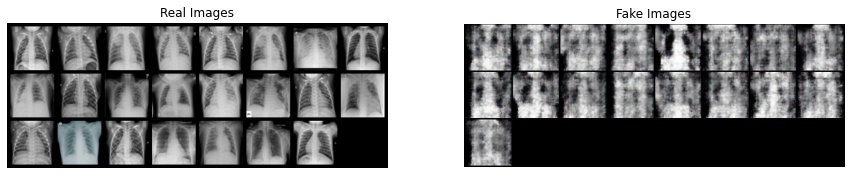

In [144]:
test2(generator, discriminator, num_epochs, metrics, train_loader)

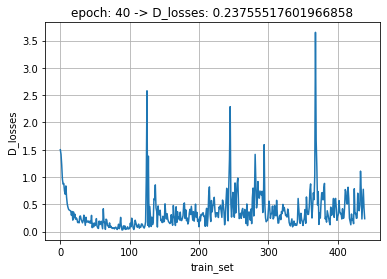

In [145]:
save_model(generator, discriminator, optimizerG, optimizerD, metrics, num_epochs)

Discriminator s o/p tensor([[1.5856e-03],
        [5.1894e-04],
        [8.8652e-03],
        [3.1105e-02],
        [2.6212e-03],
        [8.0115e-01],
        [5.8071e-04],
        [4.8618e-05],
        [2.3253e-02],
        [1.4318e-01],
        [2.6900e-02],
        [4.3286e-02],
        [1.1569e-02],
        [1.5959e-03],
        [2.7212e-02],
        [1.6296e-04]], device='cuda:0', grad_fn=<SigmoidBackward>)
Discriminator c o/p tensor([[0.1067, 0.2217, 0.6716],
        [0.2264, 0.1967, 0.5769],
        [0.5178, 0.1458, 0.3364],
        [0.3396, 0.6099, 0.0505],
        [0.3247, 0.3300, 0.3454],
        [0.0205, 0.2692, 0.7103],
        [0.2141, 0.7482, 0.0377],
        [0.5037, 0.3086, 0.1877],
        [0.0494, 0.0968, 0.8538],
        [0.1841, 0.7322, 0.0837],
        [0.9952, 0.0021, 0.0027],
        [0.0128, 0.0716, 0.9156],
        [0.8354, 0.1367, 0.0278],
        [0.0643, 0.1504, 0.7853],
        [0.0114, 0.1035, 0.8851],
        [0.0213, 0.0461, 0.9326]], device='cuda:0', g

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


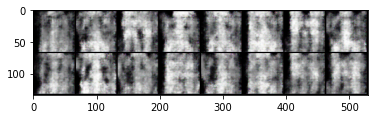

In [146]:
test_batch = 16
test_fake = 1

if test_fake:
  #check for fake image
  test_img_list = []
  test_noise = torch.randn(test_batch, nz, 1, 1, device=device)
  test_img = generator(test_noise)#.detach().cpu()

else:
  #check for real image
  test_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch,
                                            shuffle=True)
  data = next(iter(test_loader))
  test_noise, test_class_lable = data
  test_img.data.resize_(test_noise.size()).copy_(test_noise)
  #print(data[0].size())
  print('class label for real', test_class_lable)

s_output,c_label_op = discriminator(test_img.detach().to(device))
print('Discriminator s o/p', s_output)
print('Discriminator c o/p', c_label_op)

# label = np.random.randint(0, nb_label, batch_size)
# c_label.data.resize_(batch_size).copy_(torch.from_numpy(label))
# print(c_label)

test_img = test_img.detach().cpu()
test_img_list.append(vutils.make_grid(test_img, padding=2, normalize=True))
plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))